In [7]:
# Compare the nudging runs

import cccmautils as cutl
import constants as con
import pandas as pd
import numpy.ma as ma
import scipy.io as sio
import matplotlib.lines as mlines
%matplotlib inline


# This notebook was split off from PHT_compare.
# Remove the PHT stuff. Just for .nc maps for now.
# March 15, 2016


# @@ March 14, 2016 TODO:
#
#  x-consider renaming comparisons: 
#          ICE_cold (ICE), ICE_warm (ICE2)
#          CO2_hi (CO2), CO2_lo (CO22)
#     OR: ICEcold, ICEwarm, CO2hi, CO2lo
#  x-swap the non-linearity subtraction: full - (ice+co2)[ice2+co22]  
#  x-then remake 1st 100 vs last 100 figures and can delete all the old mixed up figs.
#
#  -compare preipreiice to piControl (iga), specifically the arctic ocean. 
#      what is the forcing doing to our ocean?
#  -calc trend in SAT, SLP in first 100 years vs last 100 years in e/ sim?
#  -plot monthly, seasonal (eventually, daily) variance/std dev of SAT, SLP, Z500?
#  x-plot precip: what does ITCZ do? PNW rain?
#  x-timeseries of latitude and/or height averaged temp. Maybe also humidity.
#         curious how quickly the remote atmospheric SAT changes
#
# Can we explain the full response with the separate influences?
# Eddy-driven jet versus polar night jet? subtropical jet vs polar jet.
#    Do they respond in different ways to e/ forcing?
# What climate change processes can be attributed to sea ice loss?
#    Summer, spring: hydroclimate
#    Winter: weather/storms
# Two avenues:
#   1. linearity, general circulation and annual climate -- e.g. JAS
#   2. role of sea ice loss in spring/summer climate (impacts) -- GRL, JClim?

 


printtofile=False


timeseries = True # load timeseries data. Else climo

domonth=False # otherwise do season
sea='ANN'
mo=1
#sea=None; mo=0 #@@@@

last100=True
includeyr1=True

basedir='/HOME/rkm/work/DATA/CanESM2/'
fldsuff=''

if last100:
    timeper1='3022-3121'; timeper2='2552-2651'; 
    timesel1='3022-01-01,3121-12-31'; timesel2='2552-01-01,2651-12-31'; 

    timepertmp='2921-3021'; timepertmp2='2642-2741'
    timeseltmp='2922-01-01,3021-12-31'; timeseltmp2='2642-01-01,2741-12-31'
    
    suff='last100yrof200' # for figure names
elif last200: #@@@@ note these files don't exist....
    timeper1='2922-3121'; timeper2='2452-2651'; 
    timesel1='2922-01-01,3121-12-31'; timesel2='2452-01-01,2651-12-31'; 

    timepertmp='2921-3021'; timepertmp2='2542-2741'
    timeseltmp='2922-01-01,3021-12-31'; timeseltmp2='2542-01-01,2741-12-31'
    
    suff='last200yrof200' # for figure names
    
else: # first 100 years
    if includeyr1:
        timeper1='2921-3021'; timeper2='2451-2551'; 
        timesel1='2921-01-01,3021-12-31'; timesel2='2451-01-01,2551-12-31'; 

        timepertmp=timeper1; timepertmp2=timeper2
        timeseltmp=timesel1; timeseltmp2=timesel2

        suff='first101yr' # for figure names
    else:
        timeper1='2921-3021'; timeper2='2451-2551'; 
        timesel1='2922-01-01,3021-12-31'; timesel2='2452-01-01,2551-12-31'; 

        timepertmp=timeper1; timepertmp2=timeper2
        timeseltmp=timesel1; timeseltmp2=timesel2

        suff='first100yr' # for figure names

    
casenames = ('preipreiice', 'prei2xco2iceb','pi2xco2ipulse', '2xco22xco2ice','2xco2preiice')

# 2xco2preiice 2532-2631 # not done....

# 2xco22xco2ice 2552-2651
# preipreiice 3022-3121
# prei2xco2iceb 3022-3121

# pi2xco2ipulse 2921-3021 # not extended...


timepers = {'preipreiice': timeper1, 'prei2xco2iceb': timeper1, 
            'pi2xco2ipulse': timepertmp, '2xco22xco2ice': timeper2,
            '2xco2preiice': timepertmp2} # for file names
timesels = {'preipreiice': timesel1, 'prei2xco2iceb': timesel1, 
            'pi2xco2ipulse': timeseltmp, '2xco22xco2ice': timesel2,
            '2xco2preiice': timeseltmp2} # for .nc selection
colors = {'preipreiice': 'k', 'prei2xco2iceb': 'b', 
            'pi2xco2ipulse': 'cyan', '2xco22xco2ice': 'r',
            '2xco2preiice': 'pink'}


if domonth:
    seasonalizedt={'mo':mo}
else:
    seasonalizedt={'season':sea}



if timeseries:
    ttype='timeseries'
    addsig=True
    sigstr='sig'
else:
    ttype='climo'
    addsig=False

# ===== set up constants and conversions =====

Cp=1004 # specific heat at const pressure (J/K/kg)
Lv=2.5e6 # specific heat of condensation (latent heat of vapo) at 0C(?@@) (J/kg)
erad = con.get_earthrad() # m
grav = con.get_g() # m/s2

# 1 cal = 4.186J
# convert to cal / day
# J/s -> cal/day
W2calperday = (60*60*24)/4.186


# ===== get coordinate and util data =====
lat = con.get_t63lat()
lon = con.get_t63lon()
#lev = con.get_t63lev() # 37 levs
# temp file to get level
fname=basedir + 'preipreiice/ts/preipreiice_u_2921-3021_ts.nc' # 22 levs
lev = cnc.getNCvar(fname,'plev')
dp = np.diff(lev)
nlon = len(lon)-1 # removing extra lon for zonal calcs


cellareas=con.get_t63cellareas()
latcircles=cellareas.sum(axis=1)




lat: squeezing data upon read all
lon: squeezing data upon read all
plev: squeezing data upon read all


In [8]:
# NC Field Funcs

def load_ncfield(field, ncfield, zonal=True,conv=1,mo=0,season=None):
    """ zonal can also be a region, defined in regiondict in constants.py
        returns dictionaries: full field, time mean, zonal mean
    """
    seasonalizedt = {'mo':mo, 'season': season}
    
    ncflddt={}; ncfldtmdt={}; ncfldzmdt={}
    for casename in casenames:

        fname= basedir + casename +'/ts/' + casename + '_' + field + '_' + timepers[casename] + '_ts.nc'
        timesel=timesels[casename]

        fld=cnc.getNCvar(fname,ncfield,timesel=timesel)*conv # remlon not operational??? why commented out??
        print fname + ', fld.shape ' + str(fld.shape) # @@@


        if timeseries: # do not time average (actually save time average anyway)
            fld = cutl.seasonalize(fld,**seasonalizedt)
            fldtm = fld
            # zonal average
            if zonal==True:
                fldtmzm = fldtm[...,:-1].mean(axis=2) # remove extra lon
            elif zonal in con.get_regiondict().keys():
                
                tempo, _ = cutl.mask_region(fldtm,lat,lon,region=zonal)
                fldtmzm = tempo.mean(axis=2)                
            else:
                fldtmzm = fldtm 
            fldtm = fldtmzm.mean(axis=0)
        else:
            # seasonal & time mean
            fldtm = np.mean(cutl.seasonalize(fld,**seasonalizedt),axis=0) 
            # zonal average
            if zonal:
                fldtmzm = fldtm[...,:-1].mean(axis=1)
            elif zonal in con.get_regiondict().keys():                
                tempo, _ = cutl.mask_region(fldtm,lat,lon,region=zonal)
                fldtmzm = tempo.mean(axis=1)        
            else:
                fldtmzm = fldtm

        print 'fldtm.shape, fldtmzm.shape ' + str(fldtm.shape),str(fldtmzm.shape)
        ncflddt[casename] = fld # keep all dims
        ncfldtmdt[casename] = fldtm # time mean
        ncfldzmdt[casename] = fldtmzm # zonal mean (either w/ or w/o time dim)

    return ncflddt, ncfldtmdt, ncfldzmdt


def rem_monmean(input,incr=3):
    """
          Should handle 1D or >1D. Time must be first dimension!
          
          removes the climatological monthly mean from a timeseries that
              potentially does not include all months. 
              
              incr: number of months per year in the timeseries
                    e.g. could be Dec_yr1,Jan_yr1,Feb_yr1,Dec_yr2,Jan_yr2,Feb_yr2 
                         so incr=3
                    IF the timseries does include all months, set incr=12 (@@@TEST)
                    
              returns a tuple: timeseries w/ climo removed, the tiled climo that was removed      
    """
    ntime = input.shape[0]
    nyr = ntime/incr
    print 'incr, ntime, nyr=(ntime/incr) ' + str(incr),str(ntime),str(nyr)
    
    if input.ndim>1:
        otherdims=input.shape[1:]
        oshape = tuple(np.ones(len(otherdims)))
        tshape = (nyr,)+oshape # tile shape
        remclimo = np.zeros((incr,)+otherdims) # climatology to remove
        print 'remclimo.shape ' + str(remclimo.shape)
    else:
        tshape = (nyr,) # tile shape
        remclimo = np.zeros((incr)) # climatology to remove
        print 'remclimo.shape ' + str(remclimo.shape)
        
    # average each month separately
    for midx in range(0,incr):
        #print midx
        #print 'removing ' + str(np.mean(input[midx::incr,...],axis=0))
        remclimo[midx,...] = np.mean(input[midx::incr,...],axis=0)
        
    
    remclimot=np.tile(remclimo,tshape) # tile the climo for number of years
    print 'remclimot.shape ' + str(remclimot.shape)
    
    
    inrem = input - remclimot
    
    return inrem,remclimot


In [9]:
# TEMPERATURE FUNCS
def calc_polaramp(ctl,pert,northof=60,zonalmean=True,verb=False):
    # north of 60 / global mean? @@@
    
    wgts = np.cos(np.deg2rad(lat)) / np.sum(np.cos(np.deg2rad(lat)))
    platidx=cutl.find_nearest(lat,northof)
    
    # assume zonal mean is already done
    ctlgm = np.sum(ctl*wgts,axis=-1)
    pertgm = np.sum(pert*wgts,axis=-1)
    gmanom = pertgm-ctlgm
    if verb:
        print 'GM: ctl,pert,anom ' + str(ctlgm),str(pertgm),str(gmanom)
    
    pertpol = np.average(pert[...,platidx:],weights=wgts[platidx:],axis=-1)
    ctlpol = np.average(ctl[...,platidx:],weights=wgts[platidx:],axis=-1)
    polanom = pertpol - ctlpol
    
    if verb:
        print 'POL: ctl,pert,anom ' + str(ctlpol),str(pertpol),str(polanom) 
        
    return polanom / gmanom
    
def calc_gmanom(ctl,pert,zonalmean=True):
    
    wgts = np.cos(np.deg2rad(lat)) / np.sum(np.cos(np.deg2rad(lat)))
    
    # assume zonal mean is already done
    ctlgm = np.sum(ctl*wgts,axis=-1)
    pertgm = np.sum(pert*wgts,axis=-1)
    gmanom = pertgm-ctlgm
    
    return gmanom


def plot_nc_linearity(ncdt,ax,latlim=(-90,90), dylim=None,justcombo=False,
                      normbygm=False, ylab='',unit='',suppleg=False,addpulse=False,
                      addsig=False):

    # if norm, then normalize by global avg temp increase
    
    # looking at whether isolate ice change + isolated co2 change = full change
    #  (prei2xco2iceb - preipreiice)  +  (2xco2preiice - preipreiice) = (2xco22xco2ice - preipreiice)
    
    icelg=mlines.Line2D([],[],color='b',linewidth=2)
    iceplg=mlines.Line2D([],[],color='g',linewidth=2)
    co2lg=mlines.Line2D([],[],color='r',linewidth=2)
    fullg=mlines.Line2D([],[],color='k',linewidth=2)
    comlg=mlines.Line2D([],[],color='purple',linewidth=2)
    
    ice2lg=mlines.Line2D([],[],color='b',linewidth=1)
    co22lg=mlines.Line2D([],[],color='r',linewidth=1)
    com2lg=mlines.Line2D([],[],color='purple',linewidth=1)
    
    ls='solid'
    lw=1
    
    #tmplen = ncdt['2xco2preiice'].shape[0]-1
    
    if addsig: # better have time dim
        pico = np.mean(ncdt['prei2xco2iceb'],axis=0)
        pipi = np.mean(ncdt['preipreiice'],axis=0)
        picop = np.mean(ncdt['pi2xco2ipulse'],axis=0) 
        copi = np.mean(ncdt['2xco2preiice'],axis=0)
        coco = np.mean(ncdt['2xco22xco2ice'],axis=0)
        
        _,icepv = cutl.ttest_ind(ncdt['prei2xco2iceb'], ncdt['preipreiice'],axis=0,effdof=False)      
        _,iceppv = cutl.ttest_ind(ncdt['pi2xco2ipulse'], ncdt['preipreiice'],axis=0,effdof=False)                
        _,co2pv = cutl.ttest_ind(ncdt['2xco2preiice'], ncdt['preipreiice'],axis=0,effdof=False)           

        _,combopv = cutl.ttest_ind(ncdt['prei2xco2iceb']-ncdt['preipreiice']+(ncdt['2xco2preiice']-ncdt['preipreiice']),
                                    ncdt['2xco22xco2ice']-ncdt['preipreiice'])
        _,fullpv = cutl.ttest_ind(ncdt['2xco22xco2ice'], ncdt['preipreiice'],axis=0,effdof=False)
                 
        _,ice2pv = cutl.ttest_ind(ncdt['2xco22xco2ice'], ncdt['2xco2preiice'],axis=0,effdof=False)       
        _,co22pv = cutl.ttest_ind(ncdt['2xco22xco2ice'], ncdt['prei2xco2iceb'],axis=0,effdof=False)       

        _,combo2pv = cutl.ttest_ind(ncdt['2xco22xco2ice']-ncdt['2xco2preiice']+(ncdt['2xco22xco2ice']-ncdt['prei2xco2iceb']),
                                   ncdt['2xco22xco2ice']-ncdt['preipreiice'])
    else:
        pico = ncdt['prei2xco2iceb']
        pipi = ncdt['preipreiice']
        picop = ncdt['pi2xco2ipulse']
        copi = ncdt['2xco2preiice']
        coco = ncdt['2xco22xco2ice']
    
    ice = pico - pipi
    icep = picop - pipi
    co2 = copi - pipi
    full = coco - pipi
    ice2 = coco - copi
    co22 = coco - pico
        
    combo = ice+co2
    combo2 = ice2+co22
    
    if normbygm:
        combo = (ice+co2) / calc_gmanom(2*pipi, pico+copi)
        ice = ice / calc_gmanom(pipi,pico)
        icep = icep / calc_gmanom(pipi,picop)
        co2 = co2 / calc_gmanom(pipi,copi)
        full = full / calc_gmanom(pipi,coco)
        
        combo2 = (ice2+co22) / calc_gmanom(copi+pico, 2*coco)
        ice2 = ice2 / calc_gmanom(copi,coco)
        co22 = co22 / calc_gmanom(pico,coco)
    
    if not justcombo:
        ax.plot(lat,ice, color='b',linewidth=2)
        if addpulse:
            ax.plot(lat,icep, color='g',linewidth=2)
        ax.plot(lat,co2, color='r',linewidth=2)
        if addsig:
            ax.plot(lat[icepv<=0.05],ice[icepv<=0.05],color='b',marker='d',linestyle='none')
            ax.plot(lat[co2pv<=0.05],co2[co2pv<=0.05],color='r',marker='d',linestyle='none')
            if addpulse:
                ax.plot(lat[iceppv<=0.05],icep[iceppv<=0.05],color='g',marker='d',linestyle='none')
        
    ax.plot(lat,combo,color='purple',linewidth=2)
    if addsig:
        ax.plot(lat[combopv<=0.05],combo[combopv<=0.05],color='purple',marker='d',linestyle='none')
    
    if not justcombo:
        ax.plot(lat,ice2, color='b',linestyle=ls,linewidth=lw)
        ax.plot(lat,co22, color='r',linestyle=ls,linewidth=lw)
        if addsig:
            ax.plot(lat[ice2pv<=0.05],ice2[ice2pv<=0.05],color='b',marker='.',linestyle='none')
            ax.plot(lat[co22pv<=0.05],co22[co22pv<=0.05],color='r',marker='.',linestyle='none')

    ax.plot(lat,combo2, color='purple',linestyle=ls,linewidth=lw)    
    ax.plot(lat,full,color='k',linewidth=2)
    if addsig:
        ax.plot(lat[fullpv<=0.05],full[fullpv<=0.05],color='k',marker='d',linestyle='none')
        ax.plot(lat[combo2pv<=0.05],combo2[combo2pv<=0.05],color='purple',marker='.',linestyle='none')
        
    if justcombo:
        lgh = (comlg,com2lg,fullg)
        lgstr = ('ice+co2','ice2+co22','full')
    else:
        if addpulse:
            lgh = (icelg,iceplg,co2lg,comlg,ice2lg,co22lg,com2lg,fullg)
            lgstr = ('ice','icep','co2','ice+co2','ice2','co22','ice2+co22','full')
        else:
            lgh = (icelg,co2lg,comlg,ice2lg,co22lg,com2lg,fullg)
            lgstr = ('ice','co2','ice+co2','ice2','co22','ice2+co22','full')
    if not suppleg:
        ax.legend(lgh,lgstr,loc='best',frameon=False,ncol=len(lgstr)/3)
    ax.axhline(y=0,linestyle='--',linewidth=.5,color='k')
    if normbygm:
        ax.set_ylabel('Change in ' + ylab + ' norm by gm')
    else:
        ax.set_ylabel('Change in ' + ylab + ' ' + unit)
    ax.set_xlabel('latitude')
    ax.set_xlim(latlim)
    if dylim != None:
        ax.set_ylim(dylim)
 

def plot_nc_linearity_maps(ncdt, axs, lin='one',cmin='',cmax='',cmind='',cmaxd='',cmin2='',cmax2='',
                           conv=1, ptype='nh',suppcb=False,cmap='blue2red_w20',subtime=None,
                           screen=False,vert=False,levlim=None,suppttl=False,addsig=False,sigtype='cont',
                           latlim=None,vertptype=None,addclimcont=False,ctlconts=None,
                           nosum=False,scaledlin=False):
    """ lin = 'one' is ice and co2 (ICEcold, CO2hi)
            = 'two' is ice2 and co22 (ICEwarm, CO2lo)
            
            
        nosum: include ice+co2 panel or not?
        scaledlin: is the non-linearity panel to be scaled or not?
        
    """
    
    
    # @@ subtime not implemented yet. assume average over full time 
    #tmplen = ncdt['2xco2preiice'].shape[0]-1
    fmt='%2.1f' # clabel format
    #if ctlconts!=None:
    #    if (ctlconts < 1.).any() and (ctlconts > -1.).any():
    #    #if np.logical_and((ctlconts<1).any(),(ctlconts>-1).any()):
    #        print ctlconts
    #        fmt='%2.1f'
    
    pico = ncdt['prei2xco2iceb']
    pipi = ncdt['preipreiice']
    copi = ncdt['2xco2preiice']
    coco = ncdt['2xco22xco2ice']
    
    if lin=='one':
        _,icepv = cutl.ttest_ind(pico, pipi,axis=0,effdof=False)        
        ice = (np.mean(pico,axis=0) - np.mean(pipi,axis=0))*conv
        #icep = ncfldzmdt['pi2xco2ipulse'] - ncfldzmdt['preipreiice']    
        _,co2pv = cutl.ttest_ind(copi, pipi,axis=0,effdof=False)   
        co2 = (np.mean(copi,axis=0) - np.mean(pipi,axis=0))*conv
        #_,combopv = cutl.ttest_ind(ncdt['prei2xco2iceb'][:tmplen,...]-ncdt['preipreiice'][:tmplen,...]+(ncdt['2xco2preiice']-ncdt['preipreiice'][tmplen,...]),
        #                           ncdt['2xco22xco2ice']-ncdt['preipreiice'])
        _,combopv = cutl.ttest_ind(pico-pipi+(copi-pipi),
                                   coco-pipi)
        ctl = np.mean(pipi,axis=0)*conv
        
        suff=''
        suff1='cold'; suff2='hi'
    elif lin=='two':
        _,icepv = cutl.ttest_ind(coco, copi,axis=0,effdof=False)
        ice = (np.mean(coco,axis=0) - np.mean(copi,axis=0))*conv
        _,co2pv = cutl.ttest_ind(coco, pico,axis=0,effdof=False)
        co2 = (np.mean(coco,axis=0) - np.mean(pico,axis=0))*conv
        #_,combopv = cutl.ttest_ind(ncdt['2xco22xco2ice'][:tmplen,...]-ncdt['2xco2preiice']+(ncdt['2xco22xco2ice'][:tmplen,...]-ncdt['prei2xco2iceb'][tmplen,...]),
        #                           ncdt['2xco22xco2ice']-ncdt['preipreiice'])
        _,combopv = cutl.ttest_ind(coco-copi+(coco-pico),
                                   coco-pipi)
        ctl = np.mean(coco,axis=0)*conv
        suff='2'
        suff1='warm'; suff2='lo'
        
    _,fullpv = cutl.ttest_ind(coco, pipi,axis=0,effdof=False)
    full = (np.mean(coco,axis=0) - np.mean(pipi,axis=0))*conv
    
    if vert:
        pparams = {'cmin': cmin, 'cmax': cmax,
                   'suppcb': suppcb, 'screen': screen, 'cmap':cmap,'levlim':levlim,
                   'latlim':latlim,'ptype':vertptype}
        if cmin2 != '':
            pparams2 = {'cmin': cmin2, 'cmax': cmax2,
                       'suppcb': suppcb, 'screen': screen, 'cmap':cmap,'levlim':levlim,
                       'latlim':latlim,'ptype':vertptype}
        else:
            pparams2 = {'cmin': cmin, 'cmax': cmax,
                       'suppcb': suppcb, 'screen': screen, 'cmap':cmap,'levlim':levlim,
                       'latlim':latlim,'ptype':vertptype}
    else:
        pparams = {'ptype': ptype, 'cmin': cmin, 'cmax': cmax,
                   'suppcb': suppcb, 'cmap':cmap}
        if cmin2 != '':
            pparams2 = {'ptype': ptype, 'cmin': cmin2, 'cmax': cmax2,
                       'suppcb': suppcb, 'cmap':cmap}
        else:
            pparams2 = {'ptype': ptype, 'cmin': cmin, 'cmax': cmax,
                       'suppcb': suppcb, 'cmap':cmap}
    aii=0
    ax=axs[aii]
    if suppttl: ttl=''
    else: ttl='ice'+suff1
    if vert:
        ph2 = cplt.vert_plot(ice,lev,lat,axis=ax,title=ttl,**pparams)
        if addsig:
            cplt.addtsig(ax,icepv,lat,lev/100.,sigtype=sigtype)
        if addclimcont:
            cplt.add_contoursvert(ax,ctl,lat,lev,verb=True,clab=True,conts=ctlconts,fmt=fmt)
    else:
        bm,ph2 = cplt.kemmap(ice,lat,lon,axis=ax,title=ttl,**pparams)
        if addsig:
            cplt.addtsigm(bm,icepv,lat,lon,sigtype=sigtype)
    aii+=1    
    
    ax=axs[aii]
    if suppttl: ttl=''
    else: ttl='co2'+suff2
    if vert:
        ph = cplt.vert_plot(co2,lev,lat,axis=ax,title=ttl,suppylab=True,**pparams2)
        if addsig:
            cplt.addtsig(ax,co2pv,lat,lev/100.,sigtype=sigtype)
        if addclimcont:
            cplt.add_contoursvert(ax,ctl,lat,lev,verb=True,clab=True,conts=ctlconts,fmt=fmt)
    else:
        bm,ph = cplt.kemmap(co2,lat,lon,axis=ax,title=ttl,**pparams2)
        if addsig:
            cplt.addtsigm(bm,co2pv,lat,lon,sigtype=sigtype)
    aii+=1
    
    if not nosum:
        ax=axs[aii]
        if suppttl: ttl=''
        else: ttl='ice'+suff1+'+co2'+suff2
        if vert:
            ph = cplt.vert_plot(ice+co2,lev,lat,axis=ax,title=ttl,suppylab=True,**pparams2)
            if addclimcont:
                cplt.add_contoursvert(ax,ctl,lat,lev,verb=True,clab=True,conts=ctlconts,fmt=fmt)
        else:
            bm,ph = cplt.kemmap(ice+co2,lat,lon,axis=ax,title=ttl,**pparams2)
        aii+=1

    ax=axs[aii]
    if suppttl: ttl=''
    else: ttl='full'
    if vert:
        ph = cplt.vert_plot(full,lev,lat,axis=ax,title=ttl,suppylab=True,**pparams2)
        if addsig:
            cplt.addtsig(ax,fullpv,lat,lev/100.,sigtype=sigtype)
        if addclimcont:
            cplt.add_contoursvert(ax,ctl,lat,lev,verb=True,clab=True,conts=ctlconts,fmt=fmt)
    else:
        bm,ph = cplt.kemmap(full, lat,lon,axis=ax,title=ttl,**pparams2)
        if addsig:
            cplt.addtsigm(bm,fullpv,lat,lon,sigtype=sigtype)
    aii+=1        

    ax=axs[aii] # the linearity test
    # @@@ add scaledlin here @@@
    # e.g.  c1*ICEcold + c2*CO2lo - Full
    # @@@ Question: how to scale? how to get c1,c2? Use difference from target sea ice?
    if scaledlin:
        # compute target offset
        
    
    if suppttl: ttl=''
    else: ttl='full-(ice'+suff1 +'+co2'+suff2+')' #ttl='(ice'+suff +'+co2'+suff+')-full'
    if cmind=='': # just divide the other clims by 2
        if vert:
            phd=cplt.vert_plot(full-(ice+co2),lev,lat,axis=ax,title=ttl,
                        cmin=cmin/2,cmax=cmax/2,suppcb=suppcb,screen=screen,cmap=cmap,
                        suppylab=True,levlim=levlim,latlim=latlim,ptype=vertptype)
            if addsig:
                cplt.addtsig(ax,combopv,lat,lev,sigtype=sigtype)
            if addclimcont: # want in the linearity fig?? @@@@
                cplt.add_contoursvert(ax,ctl,lat,lev,verb=True,clab=True,conts=ctlconts,fmt=fmt)
        else:
            bm,phd=cplt.kemmap(full-(ice+co2),lat,lon,axis=ax,title=ttl,ptype=ptype,
                        cmin=cmin/2,cmax=cmax/2,suppcb=suppcb,cmap=cmap)
            if addsig:
                cplt.addtsigm(bm,combopv,lat,lon,sigtype=sigtype)
    else:
        if vert:
            phd=cplt.vert_plot(full-(ice+co2),lev,lat,axis=ax,title=ttl,
                        cmin=cmind,cmax=cmaxd,suppcb=suppcb,screen=screen,cmap=cmap,
                        suppylab=True,levlim=levlim,latlim=latlim,ptype=vertptype)
            if addsig:
                cplt.addtsig(ax,combopv,lat,lev,sigtype=sigtype)
            if addclimcont: # want in the linearity fig?? @@@@
                cplt.add_contoursvert(ax,ctl,lat,lev,verb=True,clab=True,conts=ctlconts,fmt=fmt)
        else:
            bm,phd=cplt.kemmap(full-(ice+co2),lat,lon,axis=ax,title=ttl,ptype=ptype,
                        cmin=cmind,cmax=cmaxd,suppcb=suppcb,cmap=cmap)
            if addsig:
                cplt.addtsigm(bm,combopv,lat,lon,sigtype=sigtype)
    
    return ph,ph2,phd

In [10]:
print timeseries    

cutl=reload(cutl)


deni=913.

nctmpdt, nctmptmdt, nctmpzmdt = load_ncfield('st','ST',**seasonalizedt)
ncsudt, ncsutmdt, ncsuzmdt = load_ncfield('su','SU',**seasonalizedt)
ncslpdt, ncslptmdt, ncslpzmdt = load_ncfield('pmsl','PMSL',**seasonalizedt)
ncsicdt, ncsictmdt, ncsiczmdt = load_ncfield('sicn','SICN',conv=100,**seasonalizedt)
ncsitdt, ncsittmdt, ncsitzmdt = load_ncfield('sic','SIC',conv=1/deni,**seasonalizedt)
ncpcpdt, ncpcpmdt, ncpcpzmdt = load_ncfield('pcp','PCP',conv=86400,**seasonalizedt) # total precip rate. conv from kg/m2/sec to mm/day


nctZMdt, nctZMtmdt, _ = load_ncfield('tZM','TEMP', zonal=False,**seasonalizedt)
ncuZMdt, ncuZMtmdt, _ = load_ncfield('uZM','U', zonal=False,**seasonalizedt)
ncqZMdt, ncqZMtmdt, _ = load_ncfield('qZM','SHUM', zonal=False,**seasonalizedt)
nczZMdt, nczZMtmdt, _ = load_ncfield('gzZM','PHI', zonal=False,conv=1/con.get_g(),**seasonalizedt)


nctmp850dt,nctmp850tmdt,nctmp850zmdt = load_ncfield('t85000','TEMP',**seasonalizedt)

# north atlantic avg:
ncsunadt, ncsunatmdt, ncsunazmdt = load_ncfield('su','SU',zonal='nthatlthnnh',**seasonalizedt)
# north pacific avg:
ncsupadt, ncsupatmdt, ncsupazmdt = load_ncfield('su','SU',zonal='nthpacnh',**seasonalizedt)

print nctmpdt['preipreiice'].shape
print nctmptmdt['preipreiice'].shape
print nctmpzmdt['preipreiice'].shape


True
/HOME/rkm/work/DATA/CanESM2/preipreiice/ts/preipreiice_st_3022-3121_ts.nc, fld.shape (1200, 64, 129)
fldtm.shape, fldtmzm.shape (64,) (100, 64)
/HOME/rkm/work/DATA/CanESM2/prei2xco2iceb/ts/prei2xco2iceb_st_3022-3121_ts.nc, fld.shape (1200, 64, 129)
fldtm.shape, fldtmzm.shape (64,) (100, 64)
/HOME/rkm/work/DATA/CanESM2/pi2xco2ipulse/ts/pi2xco2ipulse_st_2921-3021_ts.nc, fld.shape (1200, 64, 129)
fldtm.shape, fldtmzm.shape (64,) (100, 64)
/HOME/rkm/work/DATA/CanESM2/2xco22xco2ice/ts/2xco22xco2ice_st_2552-2651_ts.nc, fld.shape (1200, 64, 129)
fldtm.shape, fldtmzm.shape (64,) (100, 64)
/HOME/rkm/work/DATA/CanESM2/2xco2preiice/ts/2xco2preiice_st_2642-2741_ts.nc, fld.shape (1200, 64, 129)
fldtm.shape, fldtmzm.shape (64,) (100, 64)
/HOME/rkm/work/DATA/CanESM2/preipreiice/ts/preipreiice_su_3022-3121_ts.nc, fld.shape (1200, 64, 129)
fldtm.shape, fldtmzm.shape (64,) (100, 64)
/HOME/rkm/work/DATA/CanESM2/prei2xco2iceb/ts/prei2xco2iceb_su_3022-3121_ts.nc, fld.shape (1200, 64, 129)
fldtm.shape,

3.01210187917e+12 1.08965016938e+13 27.6428340381
-3.51582542377e+12 1.41604653453e+13 -24.8284596449
ANN
gms {'pi2xco2ipulse': 13.99894106148707, '2xco22xco2ice': 16.927940083643005, '2xco2preiice': 16.351662042912409, 'prei2xco2iceb': 14.089945329360877, 'preipreiice': 13.577358671769963}
nhsies
[ 11.04666481  10.89650169  13.73618935  11.06891591  14.16046535]
{'pi2xco2ipulse': 11046664810969.184, '2xco22xco2ice': 10896501693782.479, '2xco2preiice': 13736189353819.729, 'prei2xco2iceb': 11068915912919.617, 'preipreiice': 14160465345255.488}

CO2 & ICE2 SIE mismatch: -0.424275991436, 12.9987964555% of full change
   CO2 (CO2hi): sea ice is not grown enough, so CO2 isolation still has a little effect from ice melt.
   ICE2 (ICEwarm): sea ice is not grown enough, so the ice melt effect is underestimated.
CO22 & ICE SIE mismatch:-0.172414219137, 5.28235720577% of full change
   CO22 (CO2lo): sea ice is not melted enough, so the CO2 isolation still has a little effect from growth.
   ICE 

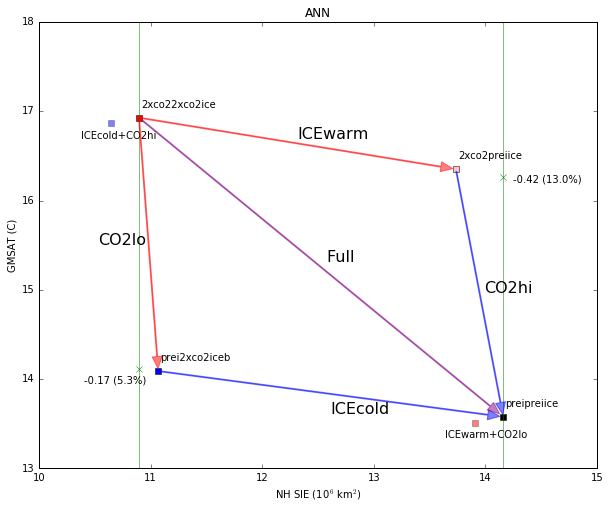

In [28]:
printtofile=False
if 1: #not timeseries:
    
    
    # @@@ TODO switch to SIA instead.
    
    
    gms ={}; nhsies={}; shsies={}
    fig,ax = plt.subplots(1,1,figsize=(10,8))
    for ii,case in enumerate(casenames):
        if timeseries: 
            vartmp = np.mean(nctmpzmdt[case],axis=0)
            sictmp = np.mean(ncsicdt[case],axis=0)/100.
        else:
            vartmp = nctmpzmdt[case]
            sictmp = ncsictmdt[case]/100.
            
        gms[case] = calc_gmanom(0,vartmp)
        nhsies[case],shsies[case] = cutl.calc_seaiceextent(sictmp,lat,lon,model=None)

        if case=='pi2xco2ipulse':
            pass
        else:
            ax.plot(nhsies[case]/1e12,gms[case], marker='s',color=colors[case])
            ax.annotate(case,(nhsies[case]/1e12,gms[case]),xytext=(2,10),textcoords='offset points')

    # add ICEcold+CO2hi  and  ICEwarm+CO2lo points to fig
    sumvecx = nhsies['prei2xco2iceb']-nhsies['2xco22xco2ice'] + nhsies['2xco2preiice']-nhsies['2xco22xco2ice']
    sumvecy = gms['prei2xco2iceb']-gms['2xco22xco2ice'] + gms['2xco2preiice']-gms['2xco22xco2ice']
    targoffset1 = sumvecx / nhsies['2xco22xco2ice'] * 100
    print sumvecx, nhsies['2xco22xco2ice'], targoffset1
    
    ax.plot((nhsies['2xco22xco2ice']+sumvecx)/1e12,
            gms['2xco22xco2ice']+sumvecy,
            marker='s',color='r',alpha=0.5)
    ax.annotate('ICEwarm+CO2lo',((nhsies['2xco22xco2ice']+sumvecx)/1e12,gms['2xco22xco2ice']+sumvecy),
                xytext=(-30,-15),textcoords='offset points')
    
    sumvecx = nhsies['prei2xco2iceb']-nhsies['preipreiice'] + nhsies['2xco2preiice']-nhsies['preipreiice']
    sumvecy = gms['prei2xco2iceb']-gms['preipreiice'] + gms['2xco2preiice']-gms['preipreiice']
    targoffset2 = sumvecx / nhsies['preipreiice'] * 100
    print sumvecx, nhsies['preipreiice'], targoffset2
    
    ax.plot((nhsies['preipreiice']+sumvecx)/1e12,
            gms['preipreiice']+sumvecy,
            marker='s',color='b',alpha=0.5)
    ax.annotate('ICEcold+CO2hi',((nhsies['preipreiice']+sumvecx)/1e12,gms['preipreiice']+sumvecy),
                xytext=(-30,-15),textcoords='offset points')
            
    print sea
    print 'gms ' + str(gms)
    print 'nhsies'
    print np.array(nhsies.values())/1e12
    print nhsies
    mm1 = nhsies['2xco2preiice']/1e12 - nhsies['preipreiice']/1e12
    pctmm1 = mm1 / (nhsies['2xco22xco2ice']/1e12 - nhsies['preipreiice']/1e12) * 100 # pct of full change
    mm2 = nhsies['2xco22xco2ice']/1e12 - nhsies['prei2xco2iceb']/1e12
    pctmm2 = mm2 / (nhsies['2xco22xco2ice']/1e12 - nhsies['preipreiice']/1e12) * 100 # pct of full change
    print '\nCO2 & ICE2 SIE mismatch: ' + str(mm1) + ', ' + str(pctmm1) + '% of full change'
    print '   CO2 (CO2hi): sea ice is not grown enough, so CO2 isolation still has a little effect from ice melt.'
    print '   ICE2 (ICEwarm): sea ice is not grown enough, so the ice melt effect is underestimated.'
    print 'CO22 & ICE SIE mismatch:' + str(mm2) + ', ' + str(pctmm2) + '% of full change'
    print '   CO22 (CO2lo): sea ice is not melted enough, so the CO2 isolation still has a little effect from growth.'
    print '   ICE (ICEcold): sea ice is not melted enough, so the ice melt effect is underestimated.'

    
    # Add Ice annotation
    ax.annotate('',xy=(nhsies['preipreiice']/1e12,gms['preipreiice']), 
                xytext=(nhsies['prei2xco2iceb']/1e12,gms['prei2xco2iceb']),
                arrowprops=dict(width=1,headlength=12,headwidth=10,
                                facecolor='b',edgecolor='b',shrink=.01,alpha=0.5))    #dict(arrowstyle='->',connectionstyle='arc3',
                                #facecolor='k',edgecolor='k')
    ax.annotate('ICEcold',xy=((nhsies['preipreiice']/1e12 + nhsies['prei2xco2iceb']/1e12)/2.,
                          (gms['preipreiice']+gms['prei2xco2iceb'])/2.), xytext=(0,-20),
                textcoords='offset points', fontsize=16) # former Ice
    # Add CO2 annotation
    ax.annotate('',xy=(nhsies['preipreiice']/1e12,gms['preipreiice']), 
                xytext=(nhsies['2xco2preiice']/1e12,gms['2xco2preiice']),
                arrowprops=dict(width=1,headlength=12,headwidth=10,
                                facecolor='b',edgecolor='b',shrink=.01,alpha=0.5))    
    ax.annotate('CO2hi',xy=((nhsies['preipreiice']/1e12 + nhsies['2xco2preiice']/1e12)/2.,
                          (gms['preipreiice']+gms['2xco2preiice'])/2.), xytext=(5,0),
                textcoords='offset points', fontsize=16) # former CO2
    # Add Ice2 annotation
    ax.annotate('',xy=(nhsies['2xco2preiice']/1e12,gms['2xco2preiice']), 
                xytext=(nhsies['2xco22xco2ice']/1e12,gms['2xco22xco2ice']),
                arrowprops=dict(width=1,headlength=12,headwidth=10,
                                facecolor='r',edgecolor='r',shrink=.01,alpha=0.5))    
    ax.annotate('ICEwarm',xy=((nhsies['2xco2preiice']/1e12 + nhsies['2xco22xco2ice']/1e12)/2.,
                          (gms['2xco2preiice']+gms['2xco22xco2ice'])/2.), xytext=(0,5),
                textcoords='offset points', fontsize=16) # former Ice2
    # Add CO22 annotation
    ax.annotate('',xy=(nhsies['prei2xco2iceb']/1e12,gms['prei2xco2iceb']), 
                xytext=(nhsies['2xco22xco2ice']/1e12,gms['2xco22xco2ice']),
                arrowprops=dict(width=1,headlength=12,headwidth=10,
                                facecolor='r',edgecolor='r',shrink=.01,alpha=0.5))    
    ax.annotate('CO2lo',xy=((nhsies['prei2xco2iceb']/1e12 + nhsies['2xco22xco2ice']/1e12)/2.,
                          (gms['prei2xco2iceb']+gms['2xco22xco2ice'])/2.), xytext=(-50,0),
                textcoords='offset points', fontsize=16) # former CO22
    # Add FULL annotation
    ax.annotate('',xy=(nhsies['preipreiice']/1e12,gms['preipreiice']), 
                xytext=(nhsies['2xco22xco2ice']/1e12,gms['2xco22xco2ice']),
                arrowprops=dict(width=1,headlength=12,headwidth=10,
                                facecolor='purple',edgecolor='purple',shrink=.01,alpha=0.5))    
    ax.annotate('Full',xy=((nhsies['preipreiice']/1e12 + nhsies['2xco22xco2ice']/1e12)/2.,
                          (gms['preipreiice']+gms['2xco22xco2ice'])/2.), xytext=(5,5),
                textcoords='offset points', fontsize=16)
    
    # Add offset from 'target ice'
    icem = (gms['preipreiice']-gms['prei2xco2iceb']) / (nhsies['preipreiice']/1e12-nhsies['prei2xco2iceb']/1e12)
    iceb = gms['prei2xco2iceb'] - (icem*nhsies['prei2xco2iceb']/1e12)
    targx = nhsies['2xco22xco2ice']/1e12
    targy = icem*targx + iceb
    print icem, iceb
    print targx,targy

    ax.plot(targx,targy,color='green',marker='x')
    ax.annotate('%2.2f'%mm2+' (%2.1f'%pctmm2+'%)', xy=(targx,targy),
                xytext=(-55,-15),textcoords='offset points')
    ax.axvline(x=targx, color='green',linewidth=.5)
    
    ice2m = (gms['2xco22xco2ice']-gms['2xco2preiice']) / (nhsies['2xco22xco2ice']/1e12-nhsies['2xco2preiice']/1e12)
    ice2b = gms['2xco2preiice'] - (ice2m*nhsies['2xco2preiice']/1e12)
    targ2x = nhsies['preipreiice']/1e12
    targ2y = ice2m*targ2x + ice2b
    print ice2m, ice2b
    print targ2x,targ2y
    
    ax.plot(targ2x,targ2y,color='green',marker='x')
    ax.annotate('%2.2f'%mm1+' (%2.1f'%pctmm1+'%)', xy=(targ2x,targ2y),
                xytext=(10,-5),textcoords='offset points')
    ax.axvline(x=targ2x, color='green',linewidth=.5)

    ax.set_xlabel('NH SIE (10$^6$ km$^2$)')
    ax.set_ylabel('GMSAT (C)')
    ax.set_title(sea)
    
    if sea=='ANN':
        ax.set_ylim((13,18))
        ax.set_xlim((10,15))
    elif sea=='JJA':
        ax.set_ylim((15,20))
        ax.set_xlim((6,11))
    elif sea=='DJF':
        ax.set_ylim((11,16))
        ax.set_xlim((10,16))
    elif sea=='SON':
        ax.set_ylim((13,18))
        ax.set_xlim((-1,12))
    if printtofile:
        fig.savefig('relaxruns_schematic_sie_gmsat_' + sea + '_' + suff + '.pdf')
        fig.savefig('relaxruns_schematic_sie_gmsat_' + sea + '_' + suff + '.jpg',dpi=300)


    

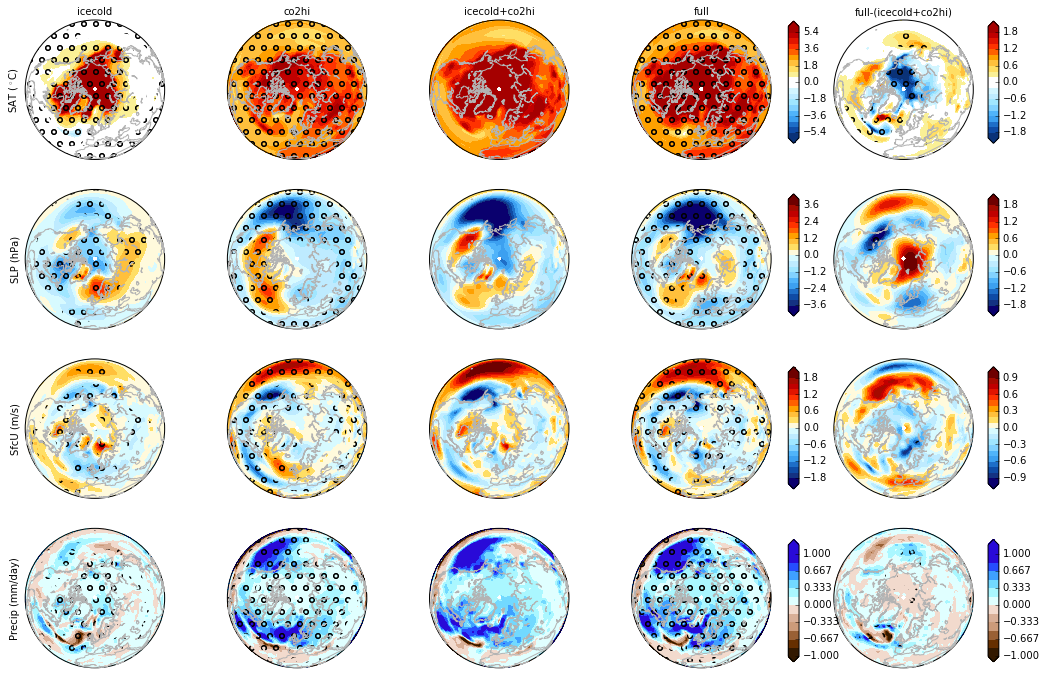

In [33]:
printtofile=False

sigtype='hatch'

if sea=='ANN':
    cmin=-6; cmax=6 # just ice
    cmin2=-6; cmax2=6
    cmind=-2; cmaxd=2

    cminp=-3; cmaxp=3 # just ice
    cmin2p=-6; cmax2p=6
    cmindp=-1.5; cmaxdp=1.5

    cminw=-1; cmaxw=1
    cmindw=-.5; cmaxdw=.5
    
    cminpr=-.6; cmaxpr=.6
    cmindpr=-.6; cmaxdpr=.6
    
elif sea=='DJF':
    cmin=-6; cmax=6 # just ice
    cmin2=-6; cmax2=6
    cmind=-2; cmaxd=2

    cminp=-4; cmaxp=4 # just ice
    cmin2p=-6; cmax2p=6
    cmindp=-2; cmaxdp=2

    cminw=-2; cmaxw=2
    cmindw=-1; cmaxdw=1
    
    cminpr=-1; cmaxpr=1
    cmindpr=-1; cmaxdpr=1

# sat, slp, sfc u
pparamst = {'cmin':cmin, 'cmax':cmax, 'cmin2':cmin2,'cmax2':cmax2,
            'cmind':cmind,'cmaxd':cmaxd,'suppcb':True,'addsig':addsig,
            'sigtype':sigtype}
pparamsp = {'cmin':cminp, 'cmax':cmaxp, 'cmap':'blue2red_20',
            'cmind':cmindp,'cmaxd':cmaxdp,'suppcb':True,'addsig':addsig,
            'sigtype':sigtype}
pparamsw = {'cmin':cminw, 'cmax':cmaxw, 'cmap':'blue2red_20',
            'cmind':cmindw,'cmaxd':cmaxdw,'suppcb':True,'addsig':addsig,
            'sigtype':sigtype}

pparamspr = {'cmin':cminpr, 'cmax':cmaxpr,'cmap':'brown2blue_12',
            'cmind':cmindpr,'cmaxd':cmaxdpr,'suppcb':True,'addsig':addsig,
            'sigtype':sigtype}

cutl=reload(cutl)



# 3 rows:
cbw=.01; cbh = .25
cbx1=.195; cbx2=.775; cbx3=.965 # not using cbx1
cby1=.68; cby2=.37; cby3=.05;

# 4 rows (after adding precip)
cbw=.01; cbh = .17
cbx1=.26; cbx2=.77; cbx3=.955
cby1=.77; cby2=.53; cby3=.29; cby4=.05


# ========== ICE and CO2

#fig,axs=plt.subplots(3,5,figsize=(15,9))
fig,axs=plt.subplots(4,5,figsize=(15,10))

ph,ph2,phd = plot_nc_linearity_maps(nctmpdt,axs[0,:],**pparamst)
#cplt.add_colorbar(fig,ph2,pos=[.195,.68,.01,.25])
cplt.add_colorbar(fig,ph,pos=[cbx2,cby1,cbw,cbh])
cplt.add_colorbar(fig,phd,pos=[cbx3,cby1,cbw,cbh])
axs[0,0].set_ylabel('SAT ($^\circ$C)')

php,ph2p,phdp = plot_nc_linearity_maps(ncslpdt,axs[1,:],suppttl=True,**pparamsp)
#cplt.add_colorbar(fig,ph2p,pos=[.195,.37,.01,.25])
cplt.add_colorbar(fig,php,pos=[cbx2,cby2,cbw,cbh])
cplt.add_colorbar(fig,phdp,pos=[cbx3,cby2,cbw,cbh])
axs[1,0].set_ylabel('SLP (hPa)')


phw,ph2w,phdw = plot_nc_linearity_maps(ncsudt,axs[2,:],suppttl=True,**pparamsw)
cplt.add_colorbar(fig,phw,pos=[cbx2,cby3,cbw,cbh])
cplt.add_colorbar(fig,phdw,pos=[cbx3,cby3,cbw,cbh])
axs[2,0].set_ylabel('SfcU (m/s)')

phpr,ph2pr,phdpr = plot_nc_linearity_maps(ncpcpdt,axs[3,:],suppttl=True,**pparamspr)
cplt.add_colorbar(fig,phpr,pos=[cbx2,cby4,cbw,cbh])
cplt.add_colorbar(fig,phdpr,pos=[cbx3,cby4,cbw,cbh])
axs[3,0].set_ylabel('Precip (mm/day)')

fig.tight_layout(pad=3,w_pad=1.9)

if printtofile:
    fig.savefig('st_slp_su_pcp_linearity1_maps_' + sea + '_nh3' + sigstr + suff +'.pdf')
    fig.savefig('st_slp_su_pcp_linearity1_maps_' + sea + '_nh3' + sigstr + suff + '.png',dpi=600)
    fig.savefig('st_slp_su_pcp_linearity1_maps_' + sea + '_nh3' + sigstr + suff + '.jpg',dpi=600)
 

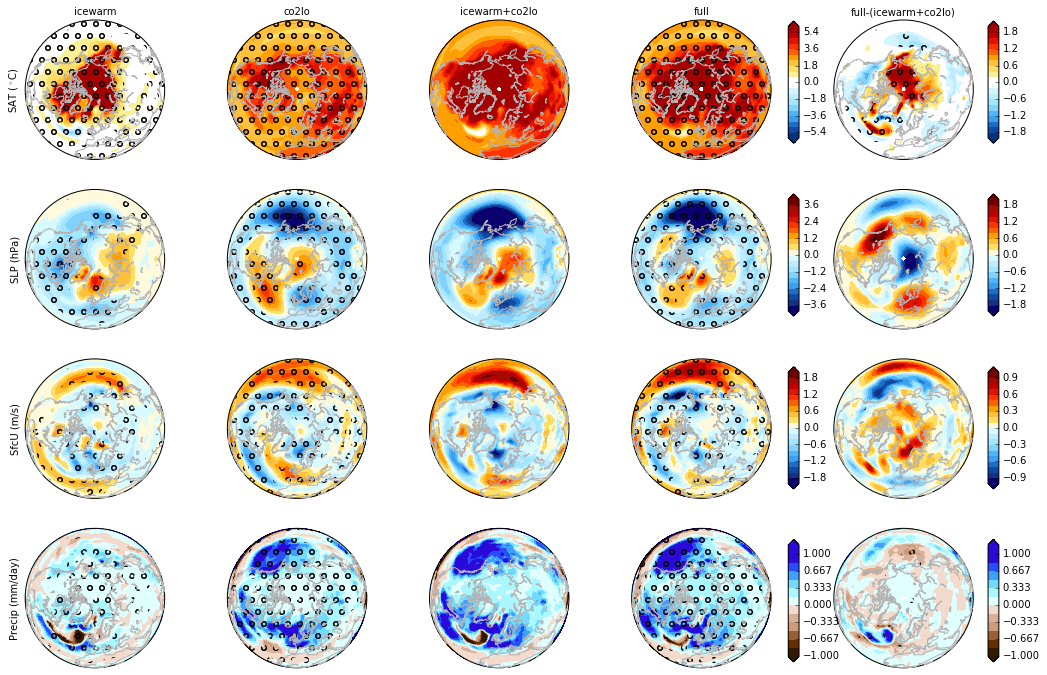

In [34]:
printtofile=False

sigtype='hatch'

if sea=='ANN':
    cmin=-6; cmax=6 # just ice
    cmin2=-6; cmax2=6
    cmind=-2; cmaxd=2

    cminp=-3; cmaxp=3 # just ice
    cmin2p=-6; cmax2p=6
    cmindp=-1.5; cmaxdp=1.5

    cminw=-1; cmaxw=1
    cmindw=-.5; cmaxdw=.5
    
    cminpr=-.6; cmaxpr=.6
    cmindpr=-.6; cmaxdpr=.6
    
elif sea=='DJF':
    cmin=-6; cmax=6 # just ice
    cmin2=-6; cmax2=6
    cmind=-2; cmaxd=2

    cminp=-4; cmaxp=4 # just ice
    cmin2p=-6; cmax2p=6
    cmindp=-2; cmaxdp=2

    cminw=-2; cmaxw=2
    cmindw=-1; cmaxdw=1

# sat, slp, sfc u
pparamst = {'cmin':cmin, 'cmax':cmax, 'cmin2':cmin2,'cmax2':cmax2,
            'cmind':cmind,'cmaxd':cmaxd,'suppcb':True,'addsig':addsig,
            'sigtype':sigtype}
pparamsp = {'cmin':cminp, 'cmax':cmaxp, 'cmap':'blue2red_20',
            'cmind':cmindp,'cmaxd':cmaxdp,'suppcb':True,'addsig':addsig,
            'sigtype':sigtype}
pparamsw = {'cmin':cminw, 'cmax':cmaxw, 'cmap':'blue2red_20',
            'cmind':cmindw,'cmaxd':cmaxdw,'suppcb':True,'addsig':addsig,
            'sigtype':sigtype}

pparamspr = {'cmin':cminpr, 'cmax':cmaxpr,'cmap':'brown2blue_12',
            'cmind':cmindpr,'cmaxd':cmaxdpr,'suppcb':True,'addsig':addsig,
            'sigtype':sigtype}

cutl=reload(cutl)



# 3 rows:
cbw=.01; cbh = .25
cbx1=.195; cbx2=.775; cbx3=.965 # not using cbx1
cby1=.68; cby2=.37; cby3=.05;

# 4 rows (after adding precip)
cbw=.01; cbh = .17
cbx1=.26; cbx2=.77; cbx3=.955
cby1=.77; cby2=.53; cby3=.29; cby4=.05


# ========== ICE and CO2

#fig,axs=plt.subplots(3,5,figsize=(15,9))
fig,axs=plt.subplots(4,5,figsize=(15,10))

ph,ph2,phd = plot_nc_linearity_maps(nctmpdt,axs[0,:],lin='two',**pparamst)
#cplt.add_colorbar(fig,ph2,pos=[.195,.68,.01,.25])
cplt.add_colorbar(fig,ph,pos=[cbx2,cby1,cbw,cbh])
cplt.add_colorbar(fig,phd,pos=[cbx3,cby1,cbw,cbh])
axs[0,0].set_ylabel('SAT ($^\circ$C)')

php,ph2p,phdp = plot_nc_linearity_maps(ncslpdt,axs[1,:],suppttl=True,lin='two',**pparamsp)
#cplt.add_colorbar(fig,ph2p,pos=[.195,.37,.01,.25])
cplt.add_colorbar(fig,php,pos=[cbx2,cby2,cbw,cbh])
cplt.add_colorbar(fig,phdp,pos=[cbx3,cby2,cbw,cbh])
axs[1,0].set_ylabel('SLP (hPa)')


phw,ph2w,phdw = plot_nc_linearity_maps(ncsudt,axs[2,:],suppttl=True,lin='two',**pparamsw)
cplt.add_colorbar(fig,phw,pos=[cbx2,cby3,cbw,cbh])
cplt.add_colorbar(fig,phdw,pos=[cbx3,cby3,cbw,cbh])
axs[2,0].set_ylabel('SfcU (m/s)')

phpr,ph2pr,phdpr = plot_nc_linearity_maps(ncpcpdt,axs[3,:],suppttl=True,lin='two',**pparamspr)
cplt.add_colorbar(fig,phpr,pos=[cbx2,cby4,cbw,cbh])
cplt.add_colorbar(fig,phdpr,pos=[cbx3,cby4,cbw,cbh])
axs[3,0].set_ylabel('Precip (mm/day)')

fig.tight_layout(pad=3,w_pad=1.9)

if printtofile:
    fig.savefig('st_slp_su_pcp_linearity2_maps_' + sea + '_nh3' + sigstr + suff +'.pdf')
    fig.savefig('st_slp_su_pcp_linearity2_maps_' + sea + '_nh3' + sigstr + suff + '.png',dpi=600)
    fig.savefig('st_slp_su_pcp_linearity2_maps_' + sea + '_nh3' + sigstr + suff + '.jpg',dpi=600)
 

In [ ]:
# Just plot SAT for paper.
# Need to add a scaled-linearity test

fig,axs=plt.subplots(4,5,figsize=(15,10))

ph,ph2,phd = plot_nc_linearity_maps(nctmpdt,axs[0,:],lin='two',**pparamst)
#cplt.add_colorbar(fig,ph2,pos=[.195,.68,.01,.25])
cplt.add_colorbar(fig,ph,pos=[cbx2,cby1,cbw,cbh])
cplt.add_colorbar(fig,phd,pos=[cbx3,cby1,cbw,cbh])
axs[0,0].set_ylabel('SAT ($^\circ$C)')


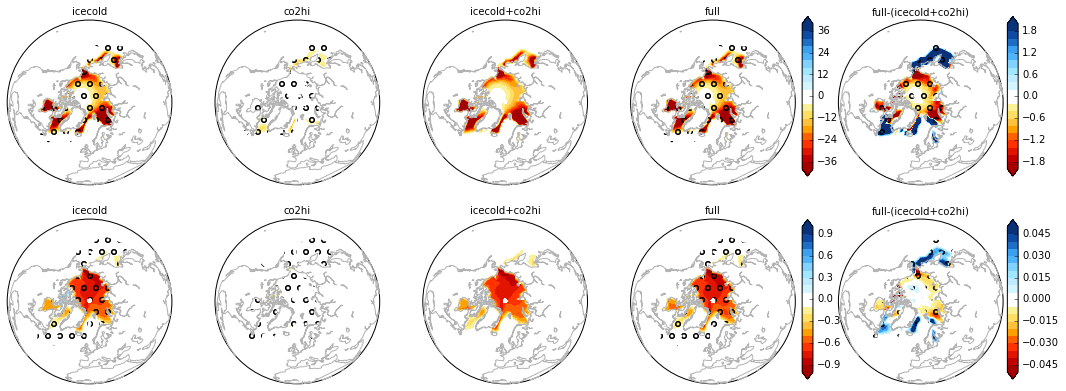

In [35]:
# PLOT SEA ICE CONC

printtofile=False

cmap='red2blue_w20'

cmin=-40; cmax=40
cmin2=-40; cmax2=40
cmind=-2; cmaxd=2 # difference is 5% of other changes

cminst=-1; cmaxst=1
#cmin2st=-.8; cmax2st=.8
cmindst=-.05; cmaxdst=.05 # difference is 5% of other changes

pparamssc = {'cmin':cmin, 'cmax':cmax, 'cmin2':cmin2,'cmax2':cmax2,
            'cmind':cmind,'cmaxd':cmaxd,'suppcb':True,'cmap':cmap,'addsig':addsig,
            'sigtype':sigtype}
pparamsst = {'cmin':cminst, 'cmax':cmaxst, 'cmap':cmap,
            'cmind':cmindst,'cmaxd':cmaxdst,'suppcb':True,'addsig':addsig,
            'sigtype':sigtype}

# ========== ICE and CO2

fig,axs=plt.subplots(2,5,figsize=(15,6))
ph,ph2,phd = plot_nc_linearity_maps(ncsicdt,axs[0,:],**pparamssc)
#cplt.add_colorbar(fig,ph2,pos=[.195,.55,.01,.37])
cplt.add_colorbar(fig,ph,pos=[.775,.55,.01,.37])
cplt.add_colorbar(fig,phd,pos=[.965,.55,.01,.37])


phst,ph2st,phdst = plot_nc_linearity_maps(ncsitdt,axs[1,:],**pparamsst)
cplt.add_colorbar(fig,phst,pos=[.775,.08,.01,.37])
cplt.add_colorbar(fig,phdst,pos=[.965,.08,.01,.37])

fig.tight_layout(pad=3,w_pad=1.9)

if printtofile:
    fig.savefig('sic_sit_linearity1_maps_' + sea + '_nh' + sigstr + suff + '.pdf')
    fig.savefig('sic_sit_linearity1_maps_' + sea + '_nh' + sigstr + suff + '.png',dpi=600)
    fig.savefig('sic_sit_linearity1_maps_' + sea + '_nh' + sigstr + suff + '.jpg',dpi=600)


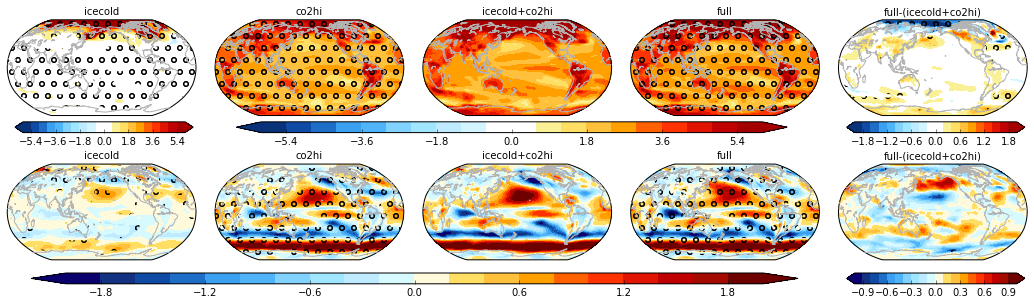

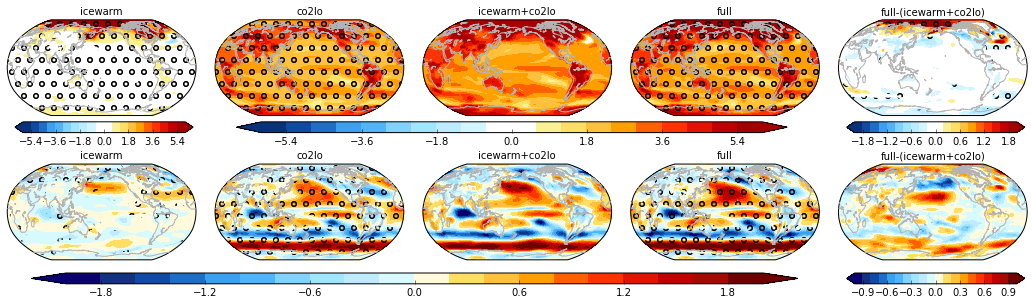

In [36]:
printtofile=False


if sea=='ANN':
    cmin=-2; cmax=2 # just ice
    cmin2=-6; cmax2=6
    cmind=-2; cmaxd=2

    cminw=-1; cmaxw=1
    cmindw=-.5; cmaxdw=.5
elif sea=='DJF':
    cmin=-6; cmax=6 # just ice
    cmin2=-6; cmax2=6
    cmind=-2; cmaxd=2

    cminp=-4; cmaxp=4 # just ice
    cmin2p=-6; cmax2p=6
    cmindp=-2; cmaxdp=2

    cminw=-2; cmaxw=2
    cmindw=-1; cmaxdw=1

pparamst = {'cmin':cmin, 'cmax':cmax, 'cmin2':cmin2,'cmax2':cmax2,
            'cmind':cmind,'cmaxd':cmaxd,'suppcb':True,'ptype':'sq','addsig':addsig,
            'sigtype':sigtype}
pparamsw = {'cmin':cminw, 'cmax':cmaxw, 'cmap':'blue2red_20',
            'cmind':cmindw,'cmaxd':cmaxdw,'suppcb':True,'ptype':'sq','addsig':addsig,
            'sigtype':sigtype}

# ========== ICE and CO2

fig,axs=plt.subplots(2,5,figsize=(15,5))
ph,ph2,phd = plot_nc_linearity_maps(nctmpdt,axs[0,:],**pparamst)
cplt.add_colorbar(fig,ph2,pos=[.035,.52,.165,.03],orientation='horizontal')
cplt.add_colorbar(fig,ph,pos=[.24,.52,.51,.03], orientation='horizontal')
cplt.add_colorbar(fig,phd,pos=[.805,.52,.165,.03], orientation='horizontal')


phw,ph2w,phdw = plot_nc_linearity_maps(ncsudt,axs[1,:],**pparamsw)
cplt.add_colorbar(fig,phw,pos=[.05,.1,.71,.03], orientation='horizontal')
#cplt.add_colorbar(fig,phw,pos=[.775,.08,.01,.37])
cplt.add_colorbar(fig,phdw,pos=[.805,.1,.165,.03], orientation='horizontal')
#cplt.add_colorbar(fig,phdw,pos=[.965,.08,.01,.37])

fig.tight_layout(pad=3,w_pad=1.9)

if printtofile:
    fig.savefig('st_su_linearity1_maps_' + sea + '_sq3' + sigstr + suff + '.pdf')
    fig.savefig('st_su_linearity1_maps_' + sea + '_sq3' + sigstr + suff + '.png',dpi=600)
    fig.savefig('st_su_linearity1_maps_' + sea + '_sq3' + sigstr + suff + '.jpg',dpi=600)
    
# ========== ICE2 and CO22

# ice2 and co22
fig,axs=plt.subplots(2,5,figsize=(15,5))
ph,ph2,phd = plot_nc_linearity_maps(nctmpdt,axs[0,:],lin='two',**pparamst)
cplt.add_colorbar(fig,ph2,pos=[.035,.52,.165,.03],orientation='horizontal')
cplt.add_colorbar(fig,ph,pos=[.24,.52,.51,.03], orientation='horizontal')
cplt.add_colorbar(fig,phd,pos=[.805,.52,.165,.03], orientation='horizontal')

phw,ph2,phdw = plot_nc_linearity_maps(ncsudt,axs[1,:],lin='two',**pparamsw)
cplt.add_colorbar(fig,phw,pos=[.05,.1,.71,.03], orientation='horizontal')
#cplt.add_colorbar(fig,phw,pos=[.775,.08,.01,.37])
cplt.add_colorbar(fig,phdw,pos=[.805,.1,.165,.03], orientation='horizontal')
#cplt.add_colorbar(fig,phdw,pos=[.965,.08,.01,.37])

fig.tight_layout(pad=3,w_pad=1.9)

if printtofile:
    fig.savefig('st_su_linearity2_maps_' + sea + '_sq3' + sigstr + suff + '.pdf')
    fig.savefig('st_su_linearity2_maps_' + sea + '_sq3' + sigstr + suff + '.png',dpi=600)
    fig.savefig('st_su_linearity2_maps_' + sea + '_sq3' + sigstr + suff + '.jpg',dpi=600)


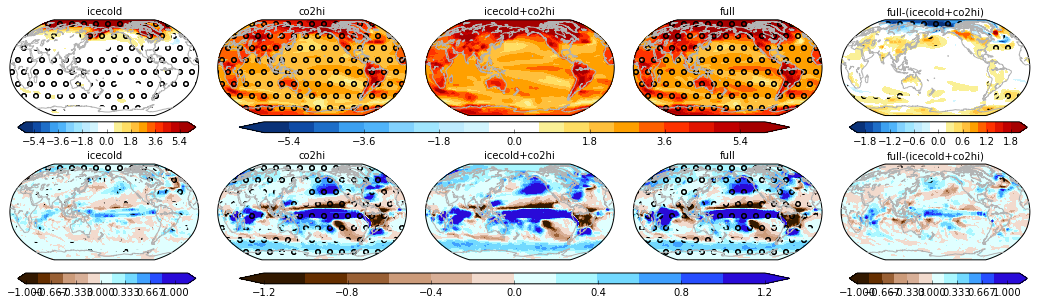

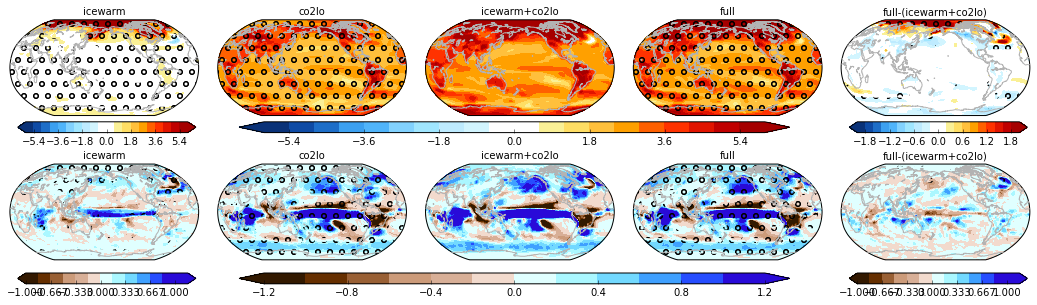

In [37]:
printtofile=False

# SAT AND PRECIP (to check out ITCZ)


if sea=='ANN':
    cmin=-2; cmax=2 # just ice
    cmin2=-6; cmax2=6
    cmind=-2; cmaxd=2

    cminw=-1; cmaxw=1
    cmindw=-.5; cmaxdw=.5
    
    cminpr=-.6; cmaxpr=.6
    cmin2pr=-1.2; cmax2pr=1.2
    cmindpr=-.6; cmaxdpr=.6
    
elif sea=='DJF':
    cmin=-6; cmax=6 # just ice
    cmin2=-6; cmax2=6
    cmind=-2; cmaxd=2

    cminp=-4; cmaxp=4 # just ice
    cmin2p=-6; cmax2p=6
    cmindp=-2; cmaxdp=2

    cminw=-2; cmaxw=2
    cmindw=-1; cmaxdw=1

pparamst = {'cmin':cmin, 'cmax':cmax, 'cmin2':cmin2,'cmax2':cmax2,
            'cmind':cmind,'cmaxd':cmaxd,'suppcb':True,'ptype':'sq','addsig':addsig,
            'sigtype':sigtype}
pparamspr = {'cmin':cminpr, 'cmax':cmaxpr, 'cmin2':cmin2pr,'cmax2':cmax2pr,'cmap':'brown2blue_12',
            'cmind':cmindpr,'cmaxd':cmaxdpr,'suppcb':True,'ptype':'sq','addsig':addsig,
            'sigtype':sigtype}

# ========== ICE and CO2

fig,axs=plt.subplots(2,5,figsize=(15,5))
ph,ph2,phd = plot_nc_linearity_maps(nctmpdt,axs[0,:],**pparamst)
cplt.add_colorbar(fig,ph2,pos=[.035,.52,.165,.03],orientation='horizontal')
cplt.add_colorbar(fig,ph,pos=[.24,.52,.51,.03], orientation='horizontal')
cplt.add_colorbar(fig,phd,pos=[.805,.52,.165,.03], orientation='horizontal')


phpr,ph2pr,phdpr = plot_nc_linearity_maps(ncpcpdt,axs[1,:],**pparamspr)
cplt.add_colorbar(fig,ph2pr,pos=[.035,.1,.165,.03],orientation='horizontal')
#cplt.add_colorbar(fig,phpr,pos=[.05,.1,.71,.03], orientation='horizontal') # spans first 4 plots
cplt.add_colorbar(fig,phpr,pos=[.24,.1,.51,.03],orientation='horizontal')
cplt.add_colorbar(fig,phdpr,pos=[.805,.1,.165,.03], orientation='horizontal')

fig.tight_layout(pad=3,w_pad=1.9)

if printtofile:
    fig.savefig('st_pcp_linearity1_maps_' + sea + '_sq3' + sigstr + suff + '.pdf')
    fig.savefig('st_pcp_linearity1_maps_' + sea + '_sq3' + sigstr + suff + '.png',dpi=600)
    fig.savefig('st_pcp_linearity1_maps_' + sea + '_sq3' + sigstr + suff + '.jpg',dpi=600)
    
# ========== ICE2 and CO22

# ice2 and co22
fig,axs=plt.subplots(2,5,figsize=(15,5))
ph,ph2,phd = plot_nc_linearity_maps(nctmpdt,axs[0,:],lin='two',**pparamst)
cplt.add_colorbar(fig,ph2,pos=[.035,.52,.165,.03],orientation='horizontal')
cplt.add_colorbar(fig,ph,pos=[.24,.52,.51,.03], orientation='horizontal')
cplt.add_colorbar(fig,phd,pos=[.805,.52,.165,.03], orientation='horizontal')

phpr,ph2pr,phdpr = plot_nc_linearity_maps(ncpcpdt,axs[1,:],lin='two',**pparamspr)
cplt.add_colorbar(fig,ph2pr,pos=[.035,.1,.165,.03],orientation='horizontal')
#cplt.add_colorbar(fig,phpr,pos=[.05,.1,.71,.03], orientation='horizontal') # spans first 4 plots
cplt.add_colorbar(fig,phpr,pos=[.24,.1,.51,.03],orientation='horizontal')
cplt.add_colorbar(fig,phdpr,pos=[.805,.1,.165,.03], orientation='horizontal')

fig.tight_layout(pad=3,w_pad=1.9)

if printtofile:
    fig.savefig('st_pcp_linearity2_maps_' + sea + '_sq3' + sigstr + suff + '.pdf')
    fig.savefig('st_pcp_linearity2_maps_' + sea + '_sq3' + sigstr + suff + '.png',dpi=600)
    fig.savefig('st_pcp_linearity2_maps_' + sea + '_sq3' + sigstr + suff + '.jpg',dpi=600)


In [14]:
from matplotlib import gridspec


def runmean(input, window=5,axis=0) :
    ret = np.cumsum(input, dtype=float,axis=axis)
    ret[window:,...] = ret[window:,...] - ret[:-window,...]
    return ret[window - 1:,...] / np.float(window)


def plot_lat_by_time(pert,ctl,lat,gspec,axrow,cmin,cmax,field=None,latlims=(0,90),
                     xticks=None,cmap='blue2red_20',run=None,monthly=False,
                     timelims=None):

    """ if monthly=True, take into acct for time average. show all 12 mo avgs
    """
    cmap=plt.get_cmap(cmap)

    incr = (cmax-cmin) /np.float(cmap.N)
    conts = np.arange(cmin,cmax+incr,incr)

    
    pltfld = pert-ctl
    print pltfld.shape
    lgstrs=('Jan', 'F','Mar','Ap', 'May',  'Jun',   'Jul',   'Au',  'S',    'O',     'N',    'D')
    clrs = ('k', 'b', 'c', 'g', 'yellow','pink', 'magenta','red','purple','orange','brown','gray')
    
    if run != None:
        pltfld = runmean(pltfld,window=run,axis=0)

    years = np.arange(0,pltfld.shape[0])
    print years.shape
    
    times,lats=np.meshgrid(years,lat)

    #fig=plt.figure(figsize=(12,4))
    gs1 = gspec #gridspec.GridSpec(1, 4)
    ##gs1.update(top=0.97,bottom=0.55,left=0.08,right=0.92,wspace=0.04)
    ax=plt.subplot(gs1[axrow,0:3]) 
    cf = ax.contourf(times,lats,pltfld.T,levels=conts,
                       vmin=cmin,vmax=cmax,cmap=cmap,extend='both')
    plt.colorbar(cf)
    ax.set_title(field)
    ax.set_ylim(latlims)
    ax.set_ylabel('latitude')
    if monthly:
        ax.set_xlabel('Month')
        #ax.xaxis.minorticks_on()
        ax.minorticks_on()
    
    else:
        ax.set_xlabel('Year')
    if timelims !=None:
        ax.set_xlim(timelims)

    ax=plt.subplot(gs1[axrow,3]) 
    if monthly and run==None:
        for midx in np.arange(0,12):
            if timelims!=None:
                tmp = pltfld[timelims[0]:timelims[1],...] # not quote right if running mean.
            else:
                tmp = pltfld
            ax.plot(tmp[midx::12,...].mean(axis=0),lat,color=clrs[midx],linewidth=2)
        ax.legend(lgstrs,loc='best',frameon=False,ncol=2)
        ax.minorticks_on()
    else:
        if timelims!=None:
            ax.plot(pltfld[timelims[0]:timelims[1],...].mean(axis=0),lat)
        else:
            ax.plot(pltfld.mean(axis=0),lat)
        
    ax.set_title(field + ' time avg')
    ax.set_ylim(latlims)
    if xticks==None:
        pass
    else:
        ax.set_xticks(xticks)
        ax.set_xlim((xticks[0],xticks[-1]))
    #fig.tight_layout()

    #return fig    

def plot_lev_by_time(pert,ctl,lev,gspec,axrow,cmin,cmax,field=None,slim=0,nlim=20,
                     xticks=None,levlim=100,cmap='blue2red_20',run=None,monthly=False,
                     timelims=None):

    """ Plots level by time
    
        assumes ctl,pert shapes are time x lev x lat
    
         field is the name of the field for saving fig and titles
         
         averages between latitude limits slim and nlim (inclusive)
         if run is not none, specifies the running mean length
         
    """
    lgstrs=('Jan', 'F','Mar','Ap', 'May',  'Jun',   'Jul',   'Au',  'S',    'O',     'N',    'D')
    clrs = ('k', 'b', 'c', 'g', 'yellow','pink', 'magenta','red','purple','orange','brown','gray')
    

    cmap=plt.get_cmap(cmap)

    incr = (cmax-cmin) /np.float(cmap.N)
    conts = np.arange(cmin,cmax+incr,incr)

    
    pltfld = pert-ctl
    pltfld = pltfld[:,:,np.logical_and(lat>=slim,lat<=nlim)].mean(axis=2)

    
    if run != None:
        pltfld = runmean(pltfld,window=run,axis=0)

    years = np.arange(0,pltfld.shape[0])
    print years.shape
    timesv,levsv=np.meshgrid(years,lev/100.)

    #fig=plt.figure(figsize=(12,4))
    gs1 = gspec #gridspec.GridSpec(1, 4)
    ##gs1.update(top=0.97,bottom=0.55,left=0.08,right=0.92,wspace=0.04)
    ax=plt.subplot(gs1[axrow,0:3]) 
    cf = ax.contourf(timesv,levsv,pltfld.T,levels=conts,
                       vmin=cmin,vmax=cmax,cmap=cmap,extend='both')
    plt.colorbar(cf)
    ax.set_title(str(slim)+'-'+str(nlim)+'N ' + field)
    ax.set_yscale('log')
    ax.set_yticks([1000,800, 500, 300, 100, 10])
    ax.set_yticklabels((1000,800,500,300,100,10))
    ax.set_ylim((levlim,1000))
    ax.set_ylabel('Pressure (hPa)')
    if monthly:
        ax.set_xlabel('Month')
    else:
        ax.set_xlabel('Year')
    ax.invert_yaxis()
    if timelims !=None:
        ax.set_xlim(timelims)

    ax=plt.subplot(gs1[axrow,3]) 
    if monthly and run==None:
        for midx in np.arange(0,12):
            if timelims!=None:
                tmp = pltfld[timelims[0]:timelims[1],...]
            else:
                tmp = pltfld
            
            ax.plot(tmp[midx::12,...].mean(axis=0),lev/100.,color=clrs[midx],linewidth=2)
        ax.legend(lgstrs,loc='best',frameon=False,ncol=2)
    else:
        if timelims!=None:
            ax.plot(pltfld[timelims[0]:timelims[1],...].mean(axis=0),lev/100.)
        else:
            ax.plot(pltfld.mean(axis=0),lev/100.)

    ax.set_title(str(slim)+'-'+str(nlim)+'N ' + field + ' time avg')
    ax.set_yscale('log')
    ax.set_yticks([1000,800, 500, 300, 100, 10])
    ax.set_yticklabels((1000,800,500,300,100,10))
    ax.set_ylim((levlim,1000))
    if xticks==None:
        pass
    else:
        ax.set_xticks(xticks)
        ax.set_xlim((xticks[0],xticks[-1]))
    ax.invert_yaxis()
    #fig.tight_layout()

    #return fig
    
    
def selectmonths(input,start=0, incr=3, weights=(0.34444444,0.34444444,0.31111111),
                 retavg=False):
    """ choose selected months but repeat until end of time dim (assume axis=0!!)
        This is for a monthly average dataset!
        
            retavg: a flag to specify whether the average of the chosen months    
                should be returned instead of the individual months
                    For example, if True, if selected months are D,J,F then 
                       timeseries of DJF means will be returned instead of D,J,F repeating
            weights are for D,J,F average into DJF seasonal mean
            
            returns either array of D,J,F OR array of DJF mean
            
    """
    nt = input.shape[0]
    #nyrs = nt/12
    rem = np.mod((nt-start),12)
    nyrs = (nt-start)/12
    print 'nyrs,remainder ' + str(nyrs),str(rem)
    if rem>=incr:
        nyrs=nyrs+1
        
    print 'nyrs ' + str(nyrs)
    
    ntout = nyrs*incr # leave off trailing months if they exist. 
    
    #print type(input[0])
    
    if input.ndim>1:
        otherdims=input.shape[1:]
    else:
        print 'selectmonths() on 1-D not supported @@@@'
        otherdims=()
        #return -1
    
    if 'datetime' in str(type(input[0])) :
        ret=[]
    else:
        if retavg:
            ret = np.zeros((nyrs,)+otherdims)
        else:
            ret = np.zeros((ntout,)+otherdims) #input.shape[1],input.shape[2]))

        print 'ret.shape ' + str(ret.shape)
    print 'nyrs ' + str(nyrs) + ', and ' + str(ntout/incr)
    
    for yridx in range(0,nyrs):
        subsamp = range(start+yridx*12,start+yridx*12+incr)
        #print yridx, subsamp # @@@
        if retavg:
            ret[yridx,...] = np.average(input[subsamp,...],weights=np.array(weights),axis=0)
        else:
            if 'datetime' in str(type(input[0])): # hack to check dates that are selected               
                ret[yridx*incr:yridx*incr+incr] = input[subsamp]
                
            else: # hack to check dates that are selected
                
                ret[yridx*incr:yridx*incr+incr,...] = input[subsamp,...]  
        
        #print 'input[subsamp,...].shape ' + str(input[subsamp,...].shape)

    return ret

In [15]:
# GET MONTHLY DATA

# get all months and remove climo for these timeseries:
nctmpmodt, _, nctmpmozmdt = load_ncfield('st','ST')
print nctmpmodt['preipreiice'].shape
print nctmpmozmdt['preipreiice'].shape

# ICEcold
ctmpmo,ctmpmoremt = rem_monmean(nctmpmozmdt['preipreiice'],incr=12)
ptmpmo = nctmpmozmdt['prei2xco2iceb'] - ctmpmoremt

print ptmpmo.shape,ctmpmo.shape


nctZMmodt, _, _ = load_ncfield('tZM','TEMP', zonal=False)
print nctZMmodt['preipreiice'].shape

ctZMmo,ctZMmoremt = rem_monmean(nctZMmodt['preipreiice'],incr=12)
ptZMmo = nctZMmodt['prei2xco2iceb'] - ctZMmoremt


# ICEwarm
ctmpiwarmmo,ctmpiwarmmoremt = rem_monmean(nctmpmozmdt['2xco2preiice'],incr=12)
ptmpiwarmmo = nctmpmozmdt['2xco22xco2ice'] - ctmpiwarmmoremt

nctZMmodt, _, _ = load_ncfield('tZM','TEMP', zonal=False)
ctZMiwarmmo,ctZMiwarmmoremt = rem_monmean(nctZMmodt['2xco2preiice'],incr=12)
ptZMiwarmmo = nctZMmodt['2xco22xco2ice'] - ctZMiwarmmoremt


ncqZMmodt, _, _ = load_ncfield('qZM','SHUM', zonal=False,conv=1000) # x1000 to make numbers more manageable
print ncqZMmodt['preipreiice'].shape

# ICEcold
cqZMmo,cqZMmoremt = rem_monmean(ncqZMmodt['preipreiice'],incr=12)
pqZMmo = ncqZMmodt['prei2xco2iceb'] - cqZMmoremt


# ICEwarm
cqZMiwarmmo,cqZMiwarmmoremt = rem_monmean(ncqZMmodt['2xco2preiice'],incr=12)
pqZMiwarmmo = ncqZMmodt['2xco22xco2ice'] - cqZMiwarmmoremt




/HOME/rkm/work/DATA/CanESM2/preipreiice/ts/preipreiice_st_3022-3121_ts.nc, fld.shape (1200, 64, 129)
No season or mo specified! Returning all months. Note month starts with 1.
fldtm.shape, fldtmzm.shape (64,) (1200, 64)
/HOME/rkm/work/DATA/CanESM2/prei2xco2iceb/ts/prei2xco2iceb_st_3022-3121_ts.nc, fld.shape (1200, 64, 129)
No season or mo specified! Returning all months. Note month starts with 1.
fldtm.shape, fldtmzm.shape (64,) (1200, 64)
/HOME/rkm/work/DATA/CanESM2/pi2xco2ipulse/ts/pi2xco2ipulse_st_2921-3021_ts.nc, fld.shape (1200, 64, 129)
No season or mo specified! Returning all months. Note month starts with 1.
fldtm.shape, fldtmzm.shape (64,) (1200, 64)
/HOME/rkm/work/DATA/CanESM2/2xco22xco2ice/ts/2xco22xco2ice_st_2552-2651_ts.nc, fld.shape (1200, 64, 129)
No season or mo specified! Returning all months. Note month starts with 1.
fldtm.shape, fldtmzm.shape (64,) (1200, 64)
/HOME/rkm/work/DATA/CanESM2/2xco2preiice/ts/2xco2preiice_st_2642-2741_ts.nc, fld.shape (1200, 64, 129)
No se

(1200, 64)
(1200,)
(1200, 64)
(1200,)


/usr/local/anaconda2-2.5.0/lib/python2.7/site-packages/ipykernel/__main__.py:73: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


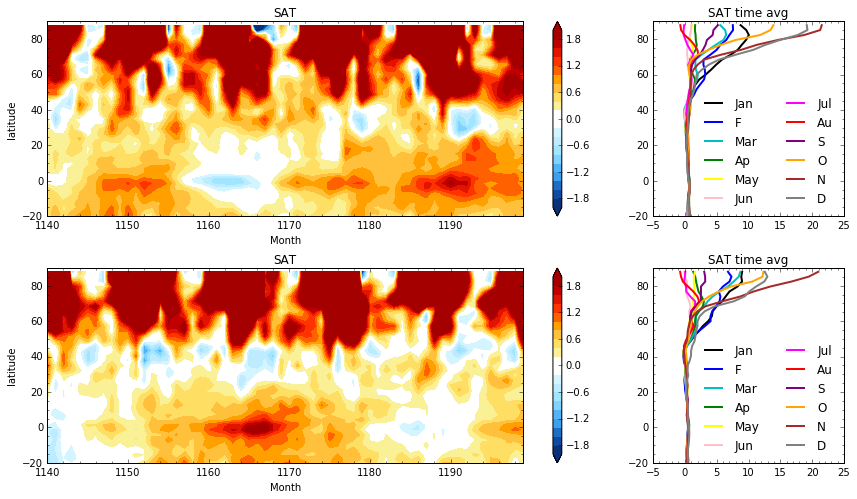

In [21]:


# @@@@ MONTHLY AVG


printtofile=False
#selmos=True; start=11; incr=3;retavg=False; prstr='DJFmo'; #@@ set window=1
#selmos=True; start=10; incr=5;retavg=False; prstr='NDJFMmo'; #@@ set window=1
#selmos=True; start=5; incr=3;retavg=False; prstr='JJAmo'; #@@ set window=1
#selmos=True; start=8; incr=3;retavg=False; prstr='SONmo'; #@@ set window=1
selmos=False; prstr='mo'

latlims=(-20,90)
timelims=(1140,1199)
monthly=True; # the data I am giving to plot func is monthly so has to be true
window=None  # None
cmin=-2;cmax=2

cname='ICEcoldICEwarm'


if window==None:
    xticks = np.arange(-5,26,5)
else:
    xticks = np.arange(-1,8,1) 
    

fig=plt.figure(figsize=(12,7))
gs1 = gridspec.GridSpec(2, 4)

if selmos:
    plot_lat_by_time(selectmonths(ptmpmo,start=start,incr=incr),selectmonths(ctmpmo,start=start,incr=incr), 
                     lat,gspec=gs1,axrow=0,cmin=cmin,cmax=cmax,field='SAT',cmap='blue2red_w20',
                     latlims=latlims,run=window,monthly=monthly,timelims=timelims,xticks=xticks)
    plot_lat_by_time(selectmonths(ptmpiwarmmo,start=start,incr=incr),selectmonths(ctmpiwarmmo,start=start,incr=incr), 
                     lat,gspec=gs1,axrow=1,cmin=cmin,cmax=cmax,field='SAT',cmap='blue2red_w20',
                     latlims=latlims,run=window,monthly=monthly,timelims=timelims,xticks=xticks)
else:
    plot_lat_by_time(ptmpmo,ctmpmo, 
                     lat,gspec=gs1,axrow=0,cmin=cmin,cmax=cmax,field='SAT',cmap='blue2red_w20',
                     latlims=latlims,run=window,monthly=monthly,timelims=timelims,xticks=xticks)
    plot_lat_by_time(ptmpiwarmmo,ctmpiwarmmo, 
                     lat,gspec=gs1,axrow=1,cmin=cmin,cmax=cmax,field='SAT',cmap='blue2red_w20',
                     latlims=latlims,run=window,monthly=monthly,timelims=timelims,xticks=xticks)
fig.tight_layout()

if printtofile:

    if timelims!=None:
        prstr = str(timelims[0])+'-' +str(timelims[1]) + prstr 
    if latlims!=None:
        prstr = '_' + prstr + str(latlims[0])+'-' + str(latlims[1])+'lat'

    if window!=None:
        prstr = prstr+'_run' + str(window)
    
    fig.savefig('stzm_' + cname + '_latxtime' + prstr + '_' + suff +'.pdf')
    fig.savefig('stzm_' + cname + '_latxtime' + prstr + '_' + suff +'.jpg',dpi=300)

(1200,)
(1200,)
(1200,)
(1200,)


/usr/local/anaconda2-2.5.0/lib/python2.7/site-packages/ipykernel/__main__.py:159: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


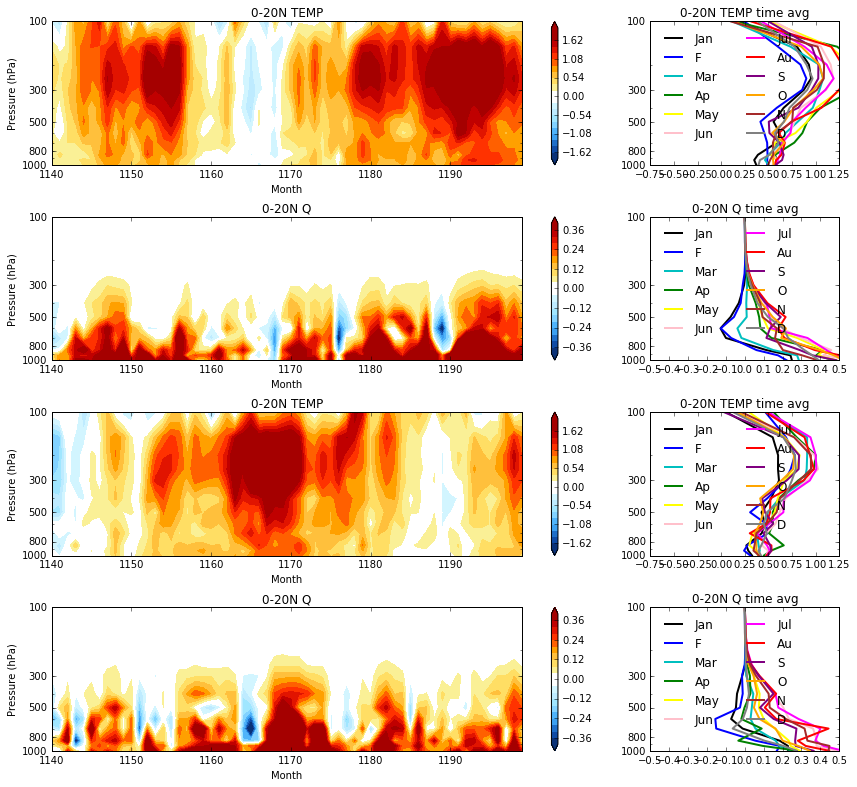

In [24]:
# @@@@ MONTHLY AVG

printtofile=False

cname='ICEcoldICEwarm'

#selmos=True; start=11; incr=3;retavg=False; prstr='DJFmo'; #@@ set window=1
#selmos=True; start=10; incr=5;retavg=False; prstr='NDJFMmo'; #@@ set window=1
#selmos=True; start=5; incr=3;retavg=False; prstr='JJAmo'; #@@ set window=1
#selmos=True; start=8; incr=3;retavg=False; prstr='SONmo'; #@@ set window=1
selmos=False; prstr='mo'


timelims=(1140,1199) #None #(0,60)
monthly=True; # the data I am giving to plot func is monthly so has to be true
cmin=-1.8;cmax=1.8
cminq=-.4; cmaxq=.4# for the ice comparison
window=None
slim=0; nlim=20
cmap='blue2red_w20'



if window==None:
    xtickst=np.arange(-0.75,1.5,0.25)
    xticksq=np.arange(-0.5,0.6,0.1)
else:
    xtickst=np.arange(-0.1,0.8,0.1)
    xticksq=np.arange(-0.04,0.18,0.04)
    

fig2=plt.figure(figsize=(12,11))
gs2 = gridspec.GridSpec(4, 4)


if selmos:
    #ICEcold
    #  TEMP
    plot_lev_by_time(selectmonths(ptZMmo,start=start,incr=incr),selectmonths(ctZMmo,start=start,incr=incr),
                     lev,gspec=gs2,axrow=0,cmap=cmap,
                     cmin=cmin,cmax=cmax,xticks=xtickst,field='TEMP',
                     run=window,monthly=monthly,timelims=timelims) # ICEcold

    #   SPEC HUM
    plot_lev_by_time(selectmonths(pqZMmo,start=start,incr=incr),selectmonths(cqZMmo,start=start,incr=incr),
                     lev,gspec=gs2,axrow=1,cmap=cmap,
                     cmin=cminq,cmax=cmaxq,field='Q',xticks=xticksq,
                     run=window,monthly=monthly,timelims=timelims) # ICEcold
    #ICEwarm
    #  TEMP
    plot_lev_by_time(selectmonths(ptZMiwarmmo,start=start,incr=incr),selectmonths(ctZMiwarmmo,start=start,incr=incr),
                     lev,gspec=gs2,axrow=2,cmap=cmap,
                     cmin=cmin,cmax=cmax,xticks=xtickst,field='TEMP',
                     run=window,monthly=monthly,timelims=timelims) # ICEcold

    #   SPEC HUM
    plot_lev_by_time(selectmonths(pqZMiwarmmo,start=start,incr=incr),selectmonths(cqZMiwarmmo,start=start,incr=incr),
                     lev,gspec=gs2,axrow=3,cmap=cmap,
                     cmin=cminq,cmax=cmaxq,field='Q',xticks=xticksq,
                     run=window,monthly=monthly,timelims=timelims) # ICEcold
else:
    #ICEcold
    #  TEMP
    plot_lev_by_time(ptZMmo,ctZMmo, lev,gspec=gs2,axrow=0,cmap=cmap,
                     cmin=cmin,cmax=cmax,xticks=xtickst,field='TEMP',
                     run=window,monthly=monthly,timelims=timelims) # ICEcold

    #   SPEC HUM
    plot_lev_by_time(pqZMmo,cqZMmo, lev,gspec=gs2,axrow=1,cmap=cmap,
                     cmin=cminq,cmax=cmaxq,field='Q',xticks=xticksq,
                     run=window,monthly=monthly,timelims=timelims) # ICEcold
    #ICEwarm
    #  TEMP
    plot_lev_by_time(ptZMiwarmmo,ctZMiwarmmo, lev,gspec=gs2,axrow=2,cmap=cmap,
                     cmin=cmin,cmax=cmax,xticks=xtickst,field='TEMP',
                     run=window,monthly=monthly,timelims=timelims) # ICEcold

    #   SPEC HUM
    plot_lev_by_time(pqZMiwarmmo,cqZMiwarmmo, lev,gspec=gs2,axrow=3,cmap=cmap,
                     cmin=cminq,cmax=cmaxq,field='Q',xticks=xticksq,
                     run=window,monthly=monthly,timelims=timelims) # ICEcold


fig2.tight_layout()

if printtofile:

    if timelims!=None:
        prstr = str(timelims[0])+'-' +str(timelims[1])+prstr
    if window!=None:
        prstr = prstr+'_run' + str(window)
    
    fig2.savefig('T_Q' + str(slim) +'-'+str(nlim)+'m_' + cname + '_levxtime_' + prstr + '_' + suff +'.pdf')
    
    

(100, 64)
(100,)
(100, 64)
(100,)


/usr/local/anaconda2-2.5.0/lib/python2.7/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


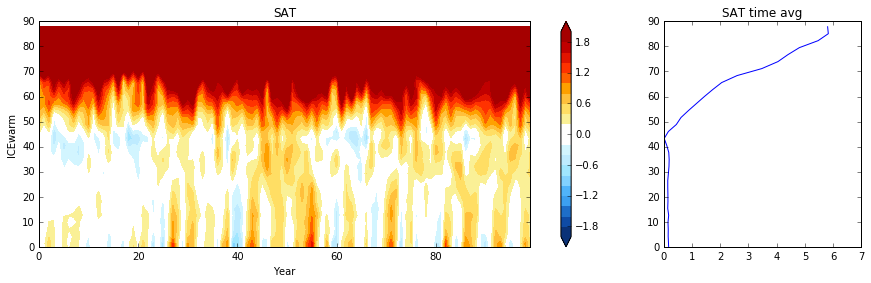

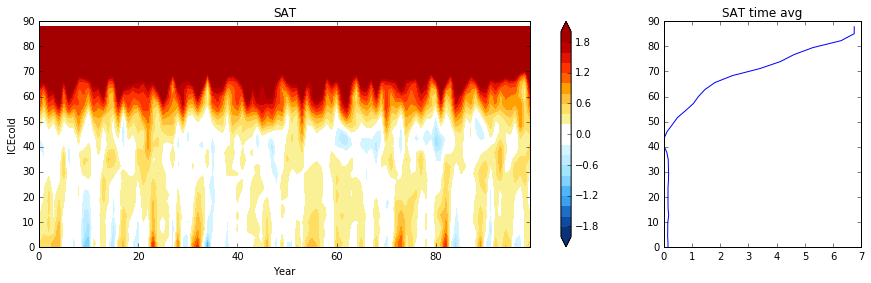

In [27]:
# @@@ SEASONAL AVG

xticks=np.arange(0,8,1)
window=1

fig = plot_lat_by_time(nctmpzmdt['2xco22xco2ice'],nctmpzmdt['2xco2preiice'], 
                 lat,cmin=cmin,cmax=cmax,field='SAT',cmap='blue2red_w20',
                latlims=(0,90),xticks=xticks,run=window)
axs=fig.get_axes()
axs[0].set_ylabel('ICEwarm')

fig = plot_lat_by_time(nctmpzmdt['prei2xco2iceb'],nctmpzmdt['preipreiice'], 
                 lat,cmin=cmin,cmax=cmax,field='SAT',cmap='blue2red_w20',
                latlims=(0,90),xticks=xticks,run=window)
axs=fig.get_axes()
axs[0].set_ylabel('ICEcold')

(91,)
(91,)


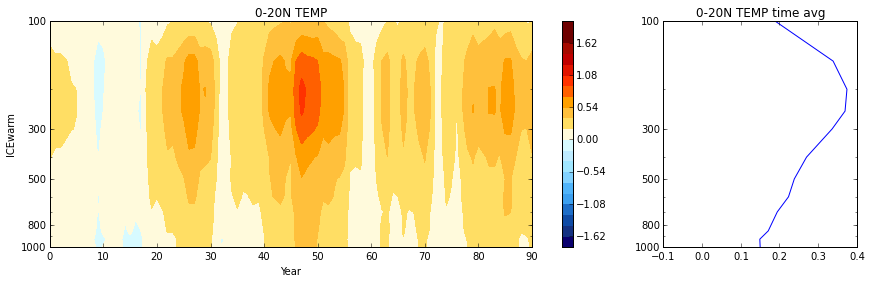

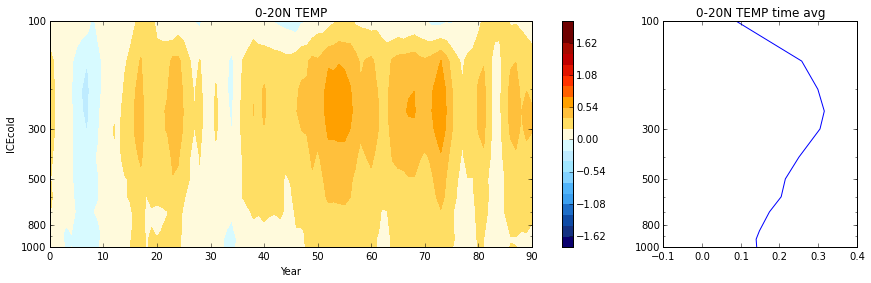

In [172]:
cmin=-1.8;cmax=1.8
xticks=np.arange(-0.1,0.5,0.1)
window=10

# should be average of 0-20N by height and time.
    
fig = plot_lev_by_time(nctZMdt['2xco22xco2ice'],nctZMdt['2xco2preiice'], lev,
                 cmin=cmin,cmax=cmax,xticks=xticks,field='TEMP',run=window) # ICEwarm
axs=fig.get_axes()
axs[0].set_ylabel('ICEwarm')


fig = plot_lev_by_time(nctZMdt['prei2xco2iceb'],nctZMdt['preipreiice'], lev,
                 cmin=cmin,cmax=cmax,xticks=xticks,field='TEMP',run=window) # ICEcold
axs=fig.get_axes()
axs[0].set_ylabel('ICEcold')

(96,)
(96,)


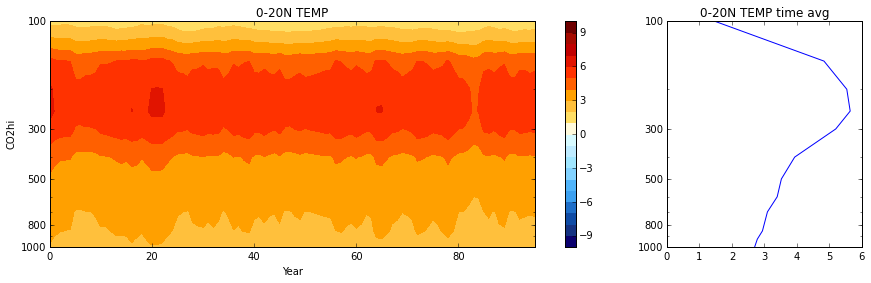

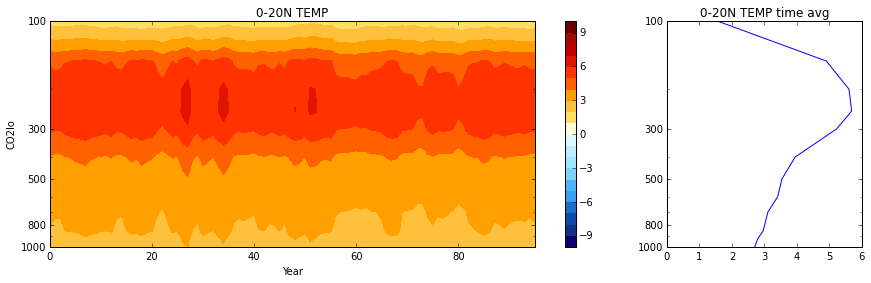

In [171]:
cmin=-10; cmax=10
xticks=np.arange(0,7,1)

fig=plot_lev_by_time(nctZMdt['2xco2preiice'],nctZMdt['preipreiice'], lev,
                 cmin=cmin,cmax=cmax,xticks=xticks,field='TEMP',run=window) # CO2hi
axs=fig.get_axes()
axs[0].set_ylabel('CO2hi')

fig=plot_lev_by_time(nctZMdt['2xco22xco2ice'],nctZMdt['prei2xco2iceb'], lev,
                 cmin=cmin,cmax=cmax,xticks=xticks,field='TEMP',run=window) # CO2hi
axs=fig.get_axes()
axs[0].set_ylabel('CO2lo')

[220 230 240 250 260 270 280 290]
[220 230 240 250 260 270 280 290]
[220 230 240 250 260 270 280 290]
[220 230 240 250 260 270 280 290]
[220 230 240 250 260 270 280 290]
[ 2000  4000  6000  8000 10000 12000 14000 16000 18000]
[ 2000  4000  6000  8000 10000 12000 14000 16000 18000]
[ 2000  4000  6000  8000 10000 12000 14000 16000 18000]
[ 2000  4000  6000  8000 10000 12000 14000 16000 18000]
[ 2000  4000  6000  8000 10000 12000 14000 16000 18000]
[-3  2  7 12 17 22 27]
[-3  2  7 12 17 22 27]
[-3  2  7 12 17 22 27]
[-3  2  7 12 17 22 27]
[-3  2  7 12 17 22 27]
[  0.5   1.    2.    4.    6.    8.   10. ]
[  0.5   1.    2.    4.    6.    8.   10. ]
[  0.5   1.    2.    4.    6.    8.   10. ]
[  0.5   1.    2.    4.    6.    8.   10. ]
[  0.5   1.    2.    4.    6.    8.   10. ]


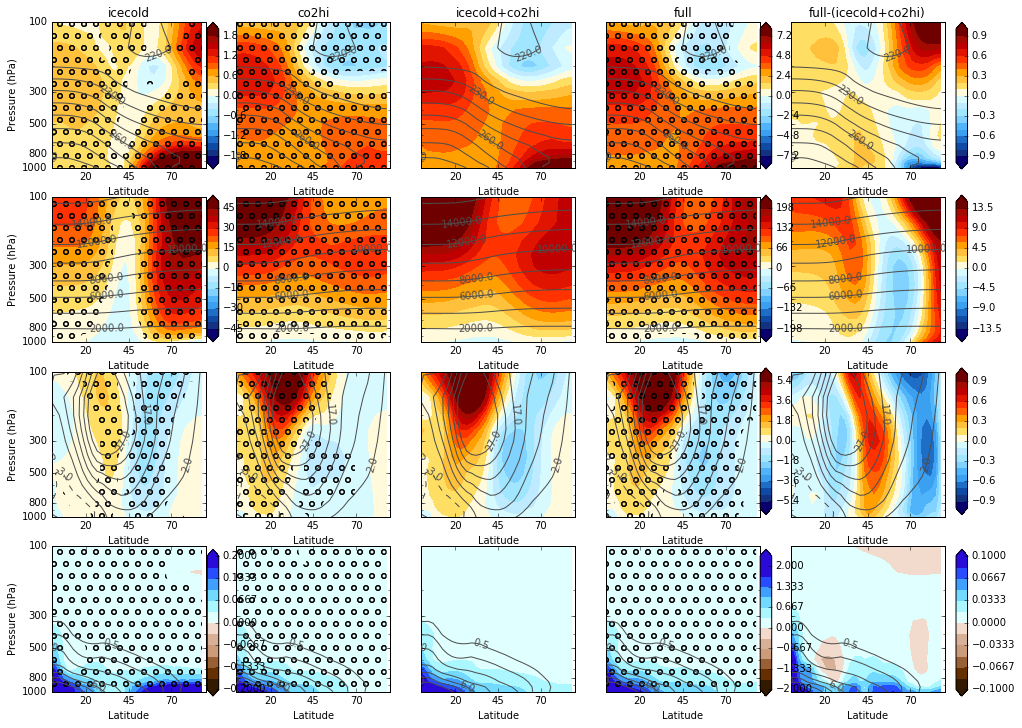

In [38]:
printtofile=False
lin='one'; linstr='1'

addsig=True
addclimcont=True

levlim=100
ptype='nh'; latlim=0 # nh plot


# T
cmin=-1; cmax=1; cmap='blue2red_20' # for the ice comparison
cmin2=-8; cmax2=8 
cmind=-.5; cmaxd=.5
ctlcontst=np.arange(220,300,10)
if sea=='DJF':
    cmin=-2; cmax=2;
    cmind=-1; cmaxd=1
    
# Z
cminz=-25; cmaxz=25; cmap='blue2red_20' # for the ice comparison
cmin2z=-200; cmax2z=200
cmindz=-15; cmaxdz=15
ctlcontsz=np.arange(2000,20000,2000)
if sea=='DJF':
    cminz=-50; cmaxz=50;
    cmin2z=-220; cmax2z=220


# U
cminw=-1; cmaxw=1 # for the ice comparison
cmin2w=-6; cmax2w=6 
cmindw=-.5; cmaxdw=.5
ctlcontsw=np.arange(-3,30,5)
if sea=='DJF':
    cminw=-6; cmaxw=6;
    cmindw=-1; cmaxdw=1
    
# Q * 1000
cminq=-.2; cmaxq=.2# for the ice comparison
cmin2q=-2; cmax2q=2  
cmindq=-.1; cmaxdq=.1
convq=1000
ctlcontsq=np.arange(-1,16,2)
ctlcontsq=np.array([.5,1,2,4,6,8,10])


pparamsT = {'cmin':cmin, 'cmax':cmax, 'cmap':cmap,'cmin2':cmin2,'cmax2':cmax2,
            'cmind':cmind,'cmaxd':cmaxd,
            'suppcb':True,'vert':True,'levlim':levlim,
            'addsig':addsig,
            'sigtype':sigtype,'latlim':latlim,'vertptype':ptype,
            'addclimcont':addclimcont,'ctlconts':ctlcontst}

pparamsZ = {'cmin':cminz, 'cmax':cmaxz, 'cmap':cmap,'cmin2':cmin2z,'cmax2':cmax2z,
            'cmind':cmindz,'cmaxd':cmaxdz,
            'suppcb':True,'vert':True,'levlim':levlim,
            'addsig':addsig,'suppttl':True,
            'sigtype':sigtype,'latlim':latlim,'vertptype':ptype,
            'addclimcont':addclimcont,'ctlconts':ctlcontsz}

pparamsU = {'cmin':cminw, 'cmax':cmaxw, 'cmap':cmap,'cmin2':cmin2w,'cmax2':cmax2w,
            'cmind':cmindw,'cmaxd':cmaxdw,
            'suppcb':True,'vert':True,'levlim':levlim,
            'addsig':addsig,'suppttl':True,
            'sigtype':sigtype,'latlim':latlim,'vertptype':ptype,
            'addclimcont':addclimcont,'ctlconts':ctlcontsw}

pparamsQ = {'cmin':cminq, 'cmax':cmaxq, 'cmap':'brown2blue_12','cmin2':cmin2q,'cmax2':cmax2q,
            'cmind':cmindq,'cmaxd':cmaxdq,
            'suppcb':True,'vert':True,'levlim':levlim,
            'addsig':addsig,'suppttl':True,
            'sigtype':sigtype,'latlim':latlim,'vertptype':ptype,
            'addclimcont':addclimcont,'ctlconts':ctlcontsq,'conv':convq}




cbw=.01; cbh = .17
cbx1=.26; cbx2=.74; cbx3=.91
cby1=.73; cby2=.53; cby3=.33; cby4=.12

# ========== ICE and CO2

cplt=reload(cplt)

fig,axs=plt.subplots(4,5,figsize=(16,12))
ph,ph2,phd = plot_nc_linearity_maps(nctZMdt,axs[0,:],lin=lin,**pparamsT)
cplt.add_colorbar(fig,ph2,pos=[cbx1,cby1,cbw,cbh])
cplt.add_colorbar(fig,ph,pos=[cbx2,cby1,cbw,cbh])
cplt.add_colorbar(fig,phd,pos=[cbx3,cby1,cbw,cbh])


phz,ph2z,phdz = plot_nc_linearity_maps(nczZMdt,axs[1,:],lin=lin,**pparamsZ)
cplt.add_colorbar(fig,ph2z,pos=[cbx1,cby2,cbw,cbh])
cplt.add_colorbar(fig,phz,pos=[cbx2,cby2,cbw,cbh])
cplt.add_colorbar(fig,phdz,pos=[cbx3,cby2,cbw,cbh])

phw,ph2w,phdw = plot_nc_linearity_maps(ncuZMdt,axs[2,:],lin=lin,**pparamsU)
if sea != 'DJF':
    cplt.add_colorbar(fig,ph2w,pos=[cbx1,cby3,cbw,cbh])
cplt.add_colorbar(fig,phw,pos=[cbx2,cby3,cbw,cbh])
cplt.add_colorbar(fig,phdw,pos=[cbx3,cby3,cbw,cbh])

phq,ph2q,phdq = plot_nc_linearity_maps(ncqZMdt,axs[3,:],lin=lin,**pparamsQ)
cplt.add_colorbar(fig,ph2q,pos=[cbx1,cby4,cbw,cbh])
cplt.add_colorbar(fig,phq,pos=[cbx2,cby4,cbw,cbh])
cplt.add_colorbar(fig,phdq,pos=[cbx3,cby4,cbw,cbh])


if printtofile:
    if addclimcont: prstr='cont'
    else: prstr=''
        
    fig.savefig('T_Z_U_Q_linearity' + linstr + '_vert_' + sea + '3' + sigstr + ptype + prstr + suff + '.pdf')
    fig.savefig('T_Z_U_Q_linearity' + linstr + '_vert_' + sea + '3' + sigstr + ptype + prstr + suff + '.png',dpi=300)
    fig.savefig('T_Z_U_Q_linearity' + linstr + '_vert_' + sea + '3' + sigstr + ptype + prstr + suff + '.jpg',dpi=300)
    

[220 230 240 250 260 270 280 290]
[220 230 240 250 260 270 280 290]
[220 230 240 250 260 270 280 290]
[220 230 240 250 260 270 280 290]
[220 230 240 250 260 270 280 290]
[ 2000  4000  6000  8000 10000 12000 14000 16000 18000]
[ 2000  4000  6000  8000 10000 12000 14000 16000 18000]
[ 2000  4000  6000  8000 10000 12000 14000 16000 18000]
[ 2000  4000  6000  8000 10000 12000 14000 16000 18000]
[ 2000  4000  6000  8000 10000 12000 14000 16000 18000]
[-3  2  7 12 17 22 27]
[-3  2  7 12 17 22 27]
[-3  2  7 12 17 22 27]
[-3  2  7 12 17 22 27]
[-3  2  7 12 17 22 27]
[  0.5   1.    2.    4.    6.    8.   10. ]
[  0.5   1.    2.    4.    6.    8.   10. ]
[  0.5   1.    2.    4.    6.    8.   10. ]
[  0.5   1.    2.    4.    6.    8.   10. ]
[  0.5   1.    2.    4.    6.    8.   10. ]


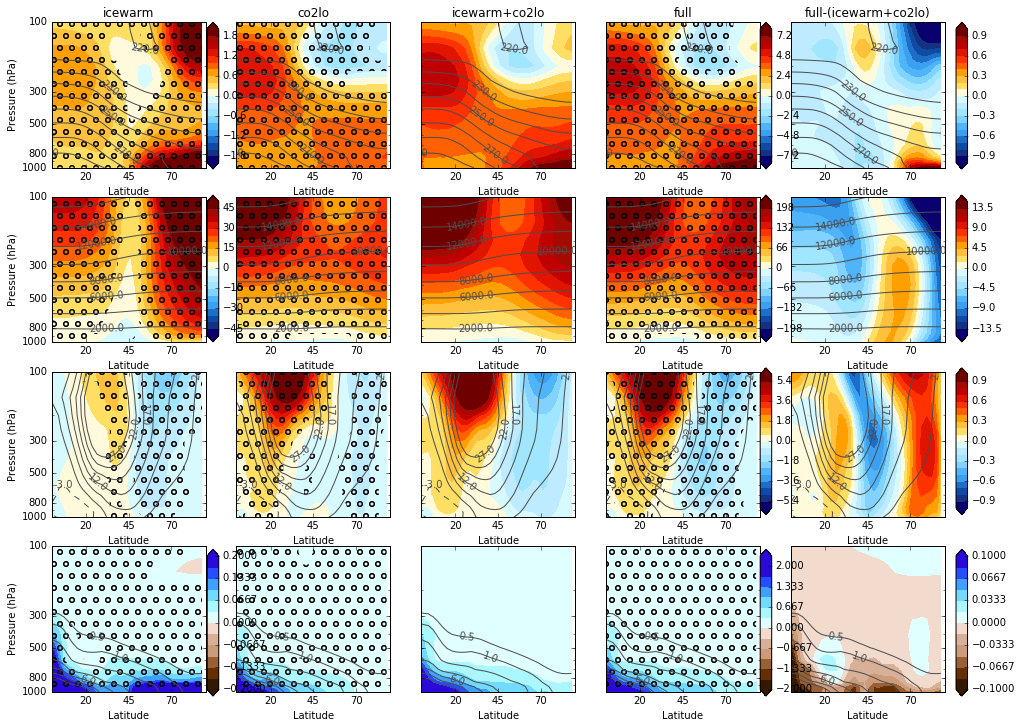

In [39]:
lin='two'; linstr='2'

# ========== ICE2 and CO22

cplt=reload(cplt)

fig,axs=plt.subplots(4,5,figsize=(16,12))
ph,ph2,phd = plot_nc_linearity_maps(nctZMdt,axs[0,:],lin=lin,**pparamsT)
cplt.add_colorbar(fig,ph2,pos=[cbx1,cby1,cbw,cbh])
cplt.add_colorbar(fig,ph,pos=[cbx2,cby1,cbw,cbh])
cplt.add_colorbar(fig,phd,pos=[cbx3,cby1,cbw,cbh])


phz,ph2z,phdz = plot_nc_linearity_maps(nczZMdt,axs[1,:],lin=lin,**pparamsZ)
cplt.add_colorbar(fig,ph2z,pos=[cbx1,cby2,cbw,cbh])
cplt.add_colorbar(fig,phz,pos=[cbx2,cby2,cbw,cbh])
cplt.add_colorbar(fig,phdz,pos=[cbx3,cby2,cbw,cbh])

phw,ph2w,phdw = plot_nc_linearity_maps(ncuZMdt,axs[2,:],lin=lin,**pparamsU)
if sea != 'DJF':
    cplt.add_colorbar(fig,ph2w,pos=[cbx1,cby3,cbw,cbh])
cplt.add_colorbar(fig,phw,pos=[cbx2,cby3,cbw,cbh])
cplt.add_colorbar(fig,phdw,pos=[cbx3,cby3,cbw,cbh])

phq,ph2q,phdq = plot_nc_linearity_maps(ncqZMdt,axs[3,:],lin=lin,**pparamsQ)
cplt.add_colorbar(fig,ph2q,pos=[cbx1,cby4,cbw,cbh])
cplt.add_colorbar(fig,phq,pos=[cbx2,cby4,cbw,cbh])
cplt.add_colorbar(fig,phdq,pos=[cbx3,cby4,cbw,cbh])


if printtofile:
    if addclimcont: prstr='cont'
    else: prstr=''
        
    fig.savefig('T_Z_U_Q_linearity' + linstr + '_vert_' + sea + '3' + sigstr + ptype + prstr + suff + '.pdf')
    fig.savefig('T_Z_U_Q_linearity' + linstr + '_vert_' + sea + '3' + sigstr + ptype + prstr + suff + '.png',dpi=300)
    fig.savefig('T_Z_U_Q_linearity' + linstr + '_vert_' + sea + '3' + sigstr + ptype + prstr + suff + '.jpg',dpi=300)
